# Data processing

In [49]:
# common packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
# from datetime import date
%matplotlib inline

# data denoising
import pywt
import copy

# feature extraction
from ta.volume import AccDistIndexIndicator
from ta.trend import MACD
from ta.volume import OnBalanceVolumeIndicator
from ta.volatility import BollingerBands

# feature normalization
from sklearn.preprocessing import MinMaxScaler
import joblib

# dimensionality reduction
from sklearn.decomposition import PCA

# Data splitting
from sklearn.model_selection import train_test_split

### Useful function and common variables

In [50]:
DIAGRAMS_PATH = "./diagrams"
SCALER_PATH = "./scaler"
TRAINING_STOCKS_PATH = "./data/processed/training_data"
EVALUATE_STOCKS_PATH = "./data/processed/stocks_for_evaluate"
TRAIN_STOCK_NAMES_PATH = "./data/processed/stock_names_for_training"
stocks_for_testing = ["1038.HK", "1299.HK", "2888.HK", "AAPL", "MSFT", "TEAM"]
stocks_for_gen_testing_only = ["2888.HK", "TEAM"] # gen = generalizability

def parse_string_to_datetime(x):
    return datetime.strptime(x, '%Y-%m-%d')


def is_stock_hk(stock_name):
    return ".HK" in stock_name


def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

### Read stock price CSVs

In [51]:
raw_marekt_data_path = "./data/raw/market_data/"

# current directory csv files;
#  ref: https://stackoverflow.com/a/55245949/9500852
csvs = [x for x in os.listdir(raw_marekt_data_path) if x.endswith('.csv')]
# stats.csv -> stats
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(raw_marekt_data_path + csvs[i])

    # parse also the date from string to Datetime object
    if not isinstance(d[fns[i]]["Date"][0], datetime):
        d[fns[i]]["Date"] = d[fns[i]]["Date"].apply(parse_string_to_datetime)

# show read csv result - Disney's stock
d["DIS"]

Date        Open        High         Low       Close    Volume  \
0    2011-09-30   26.557592   27.041898   26.407898   26.557592  15135000   
1    2011-10-03   26.443124   26.707291   25.527344   25.536150  13899200   
2    2011-10-04   25.298400   26.390290   24.822900   26.293430  19000000   
3    2011-10-05   26.724900   27.781567   26.689677   27.746346  17823700   
4    2011-10-06   27.499790   28.221847   27.314874   28.204235  12659400   
...         ...         ...         ...         ...         ...       ...   
2512 2021-09-24  175.300003  176.699997  175.080002  176.000000   5712800   
2513 2021-09-27  176.630005  179.449997  175.960007  178.259995   7755000   
2514 2021-09-28  177.750000  178.000000  173.860001  174.520004   9133100   
2515 2021-09-29  174.250000  174.960007  172.589996  172.679993   6240800   
2516 2021-09-30  173.100006  173.679993  169.100006  169.169998  13962400   

      Dividends  Stock Splits  
0           0.0             0  
1           0.0             0  
2           0.0             0  
3           0.0             0  
4           0.0             0  
...         ...           ...  
2512        0.0             0  
2513        0.0             0  
2514        0.0             0  
2515        0.0             0  
2516        0.0             0  

[2517 rows x 8 columns]

### Stock data count

In [52]:
hk_stock_row_count = 0
us_stock_row_count = 0

for i in range(len(fns)):
    if is_stock_hk(fns[i]):
        hk_stock_row_count = hk_stock_row_count + len(d[fns[i]])
    else:
        us_stock_row_count = us_stock_row_count + len(d[fns[i]])

print("Rows of HK stocks data: " + str(hk_stock_row_count))
print("Rows of US stocks data: " + str(us_stock_row_count))

Rows of HK stocks data: 121231
Rows of US stocks data: 123839


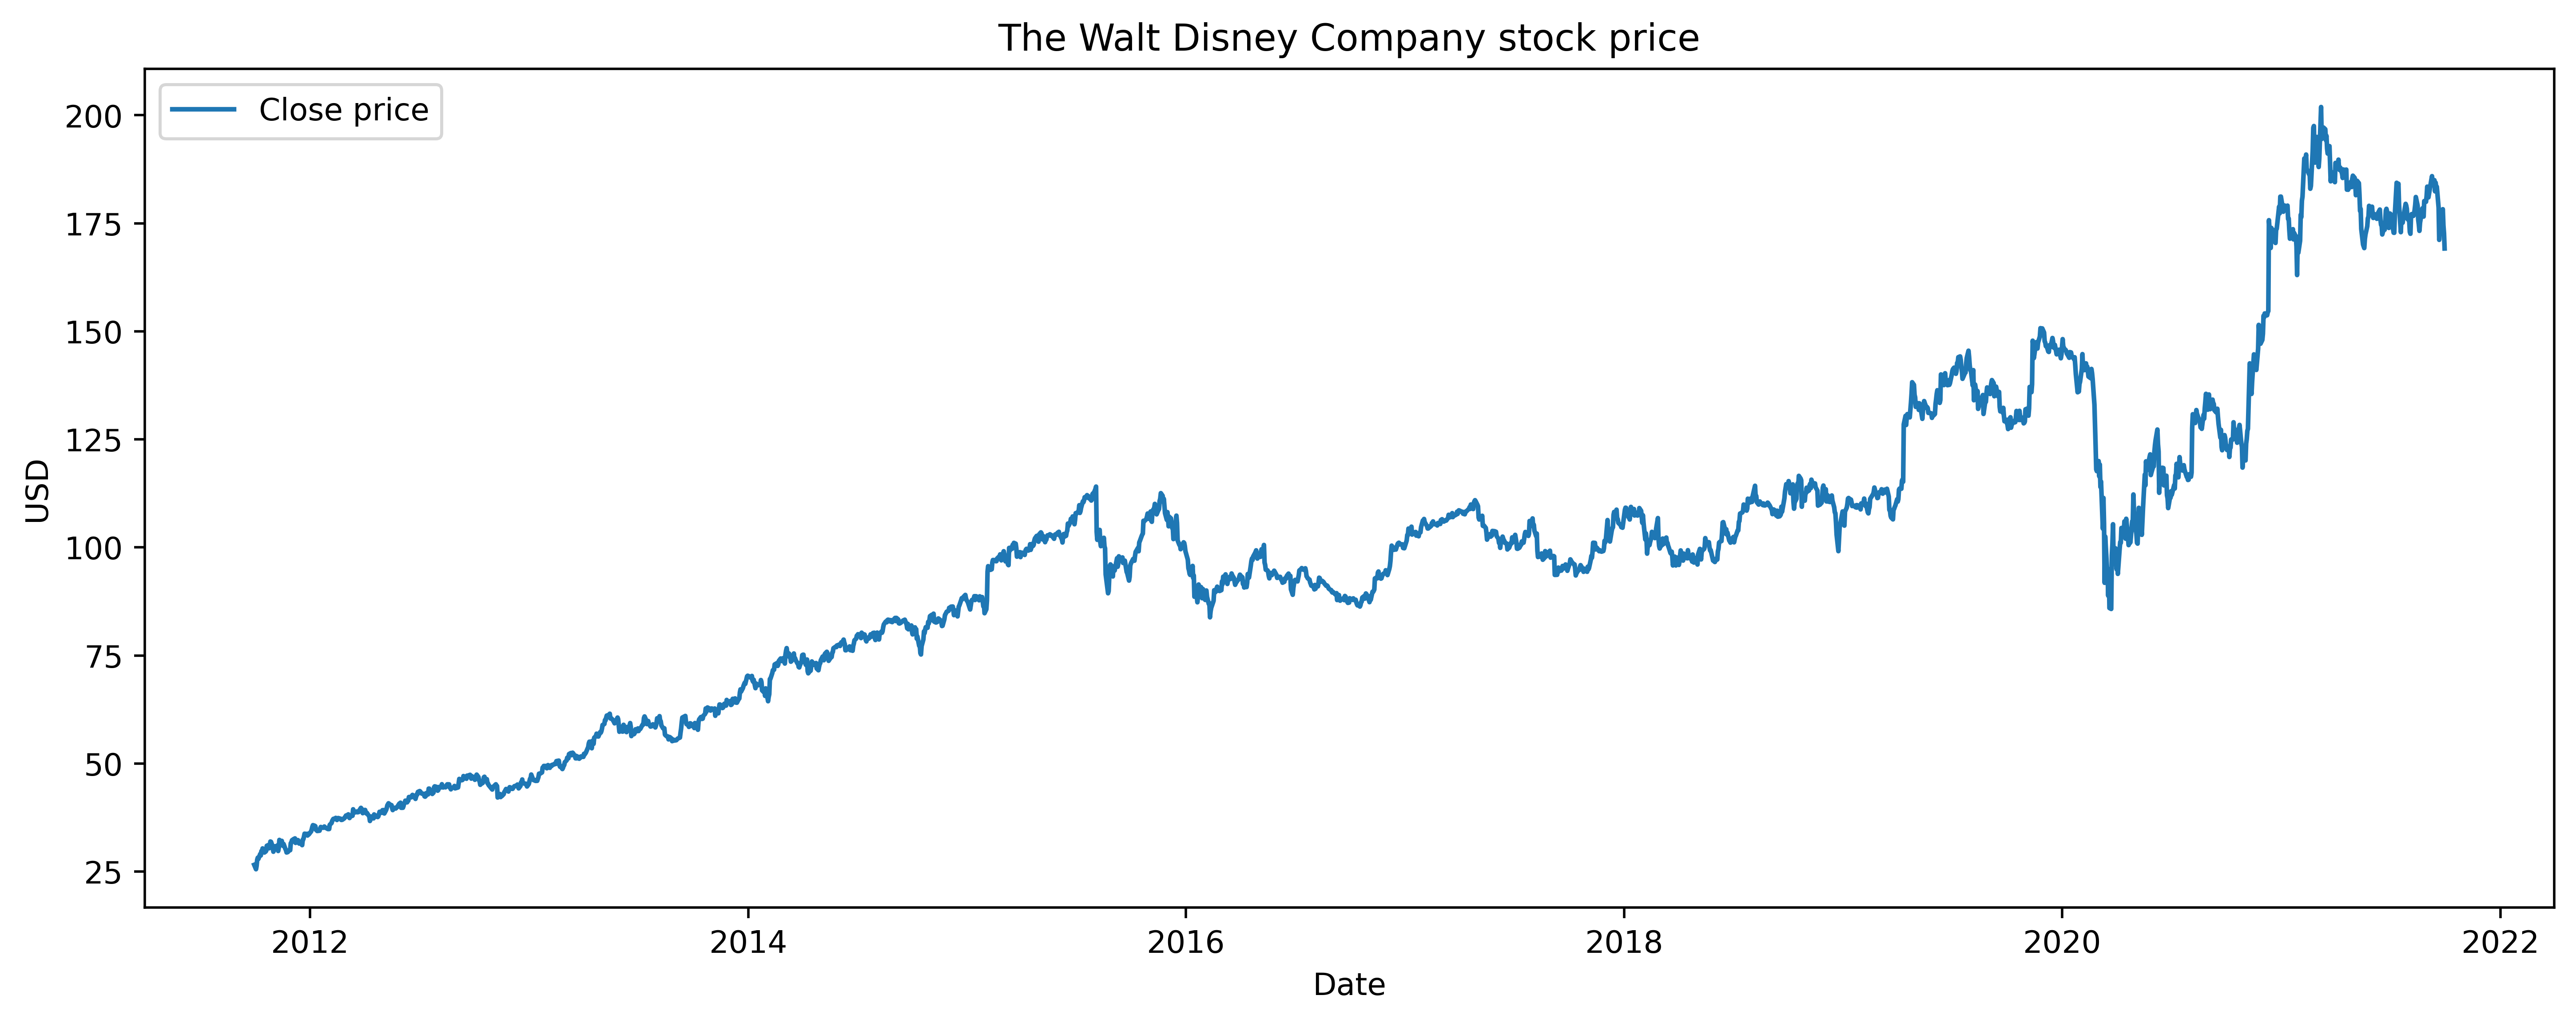

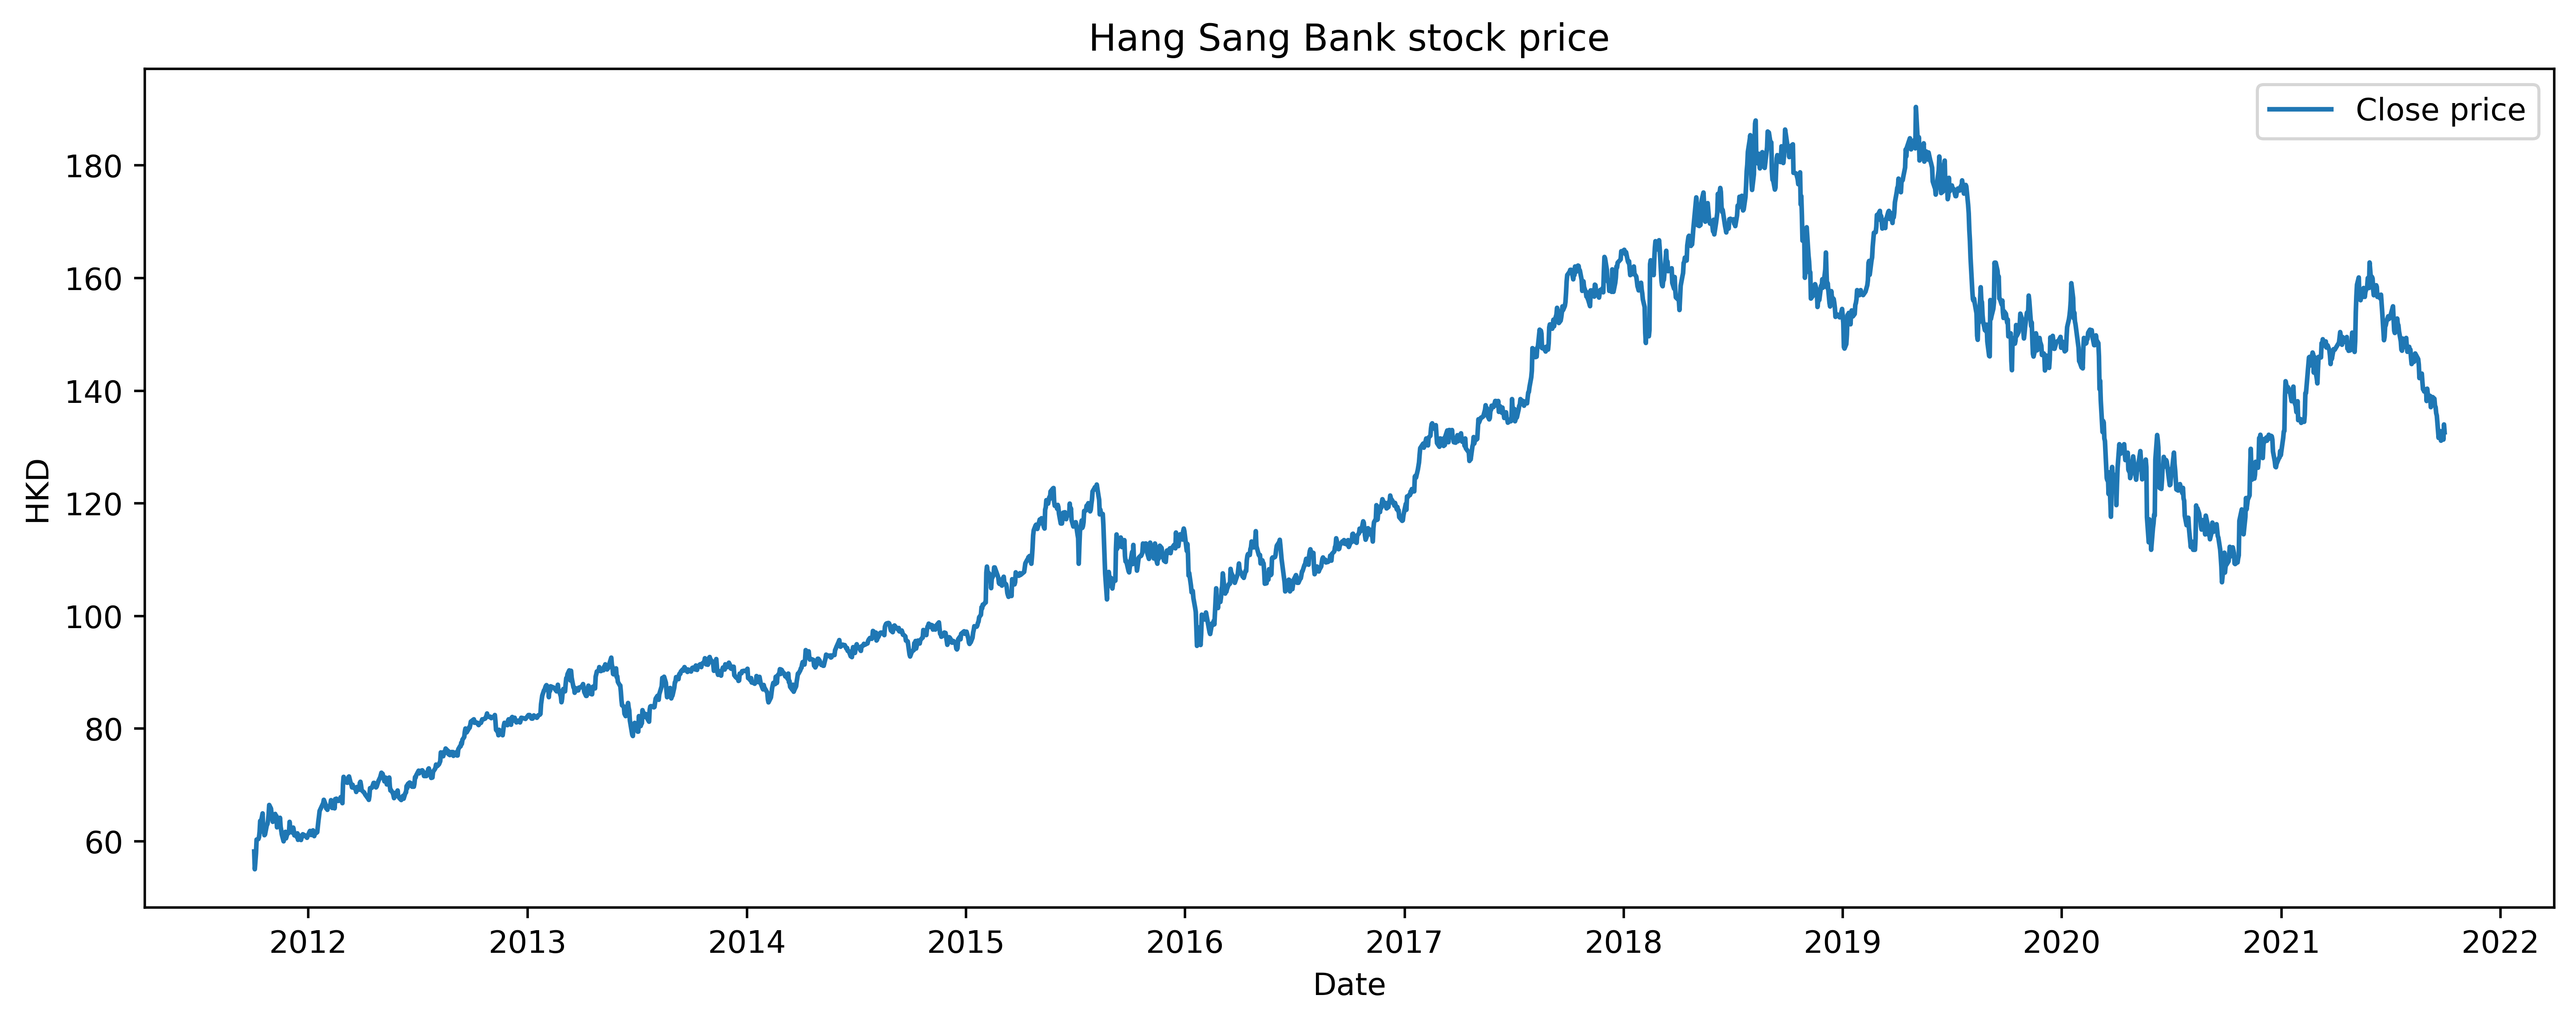

In [53]:
def plot_raw_stock_price(stock_id, title, legend_label, y_label):
    if not isinstance(d[stock_id]["Date"][0], datetime):
        d[stock_id]["Date"] = d[stock_id]["Date"].apply(parse_string_to_datetime)

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(d[stock_id]['Date'], d[stock_id]['Close'], label=legend_label)
    # plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()


# plot The Walt Disney Company (DIS) stocks price
plot_raw_stock_price("DIS",
                     'The Walt Disney Company stock price',
                     'Close price',
                     'USD'
                     )

# plot 0011.HK stocks price
plot_raw_stock_price("0011.HK",
                     'Hang Sang Bank stock price',
                     'Close price',
                     "HKD"
                     )

### Data denoising with 2-level discrete Wavelet Transform

In [54]:
def wavelet_denoise(index_list, wavefunc='haar', lv=2, m=1, n=2, plot=False):
    '''
    *** Reference **
    Obtained from: https://github.com/SunHao95/PHBS_TQFML-StockIndex-Wavelet-Transformation-ARIMA-ML-Model/blob/c1c3c11e80568663448bdc30f87dc378db0538d2/Project/model.py#L19-L68
    Edited to fit the project's requirements
    *** END ***

    WT: Wavelet Transformation Function
    index_list: Input Sequence;

    lv: Decomposing Level；

    wavefunc: Function of Wavelet, 'db4' default；

    m, n: Level of Threshold Processing

    '''

    # Decomposing
    coeff = pywt.wavedec(index_list, wavefunc, mode='sym',
                         level=lv)  #  Decomposing by levels，cD is the details coefficient
    sgn = lambda x: 1 if x > 0 else -1 if x < 0 else 0  # sgn function

    # Denoising
    # Soft Threshold Processing Method
    for i in range(m,
                   n + 1):  #  Select m~n Levels of the wavelet coefficients，and no need to dispose the cA coefficients(approximation coefficients)
        cD = coeff[i]
        Tr = np.sqrt(2 * np.log2(len(cD)))  # Compute Threshold
        for j in range(len(cD)):
            if cD[j] >= Tr:
                coeff[i][j] = sgn(cD[j]) * (np.abs(cD[j]) - Tr)  # Shrink to zero
            else:
                coeff[i][j] = 0  # Set to zero if smaller than threshold

    # Reconstructing
    coeffs = {}
    for i in range(len(coeff)):
        coeffs[i] = copy.deepcopy(coeff)
        for j in range(len(coeff)):
            if j != i:
                coeffs[i][j] = np.zeros_like(coeff[j])

    for i in range(len(coeff)):
        coeff[i] = pywt.waverec(coeffs[i], wavefunc)
        if len(coeff[i]) > len(index_list):
            coeff[i] = coeff[i][:-1]

    if plot:
        denoised_index = np.sum(coeff, axis=0)
        data = pd.DataFrame({'CLOSE': index_list, 'denoised': denoised_index})
        data.plot(figsize=(10, 10), subplots=(2, 1))
        data.plot(figsize=(10, 5))
        print(data)

    return coeff

In [55]:
d_denoised = copy.deepcopy(d)  # create copy from raw data to prevent overwrite
denoised_count = 0
for i in range(len(fns)):
    tmp_close_price = d_denoised[fns[i]]["Close"]
    coeff = wavelet_denoise(tmp_close_price)
    d_denoised[fns[i]]["Close"] = np.sum(coeff, axis=0)  # reconstruct and save to the dataframe
    denoised_count = denoised_count + 1
    print("{} OK".format(fns[i]))

print("Denoised count: {}".format(denoised_count))

UAL OK
1109.HK OK
V OK
2313.HK OK
0027.HK OK
3968.HK OK
WU OK
MSI OK
FCX OK
0003.HK OK
ADM OK
0011.HK OK
GPN OK
0857.HK OK
ARE OK
0001.HK OK
0101.HK OK
FMC OK
AIZ OK
BXP OK
1398.HK OK
0005.HK OK
0941.HK OK
0066.HK OK
2331.HK OK
0017.HK OK
1093.HK OK
0388.HK OK
2319.HK OK
0762.HK OK
2628.HK OK
1044.HK OK
RL OK
0241.HK OK
FTNT OK
JNPR OK
DHI OK
2020.HK OK
EXPE OK
1928.HK OK
KO OK
WDC OK
LUMN OK
UPS OK
MSFT OK
UDR OK
COO OK
2018.HK OK
MLM OK
0267.HK OK
AMD OK
ZBH OK
0386.HK OK
UHS OK
SBAC OK
0002.HK OK
0669.HK OK
LKQ OK
PVH OK
3988.HK OK
GD OK
CLX OK
0688.HK OK
DIS OK
0883.HK OK
LDOS OK
LEN OK
2382.HK OK
AOS OK
OMC OK
1299.HK OK
TSLA OK
TXT OK
1177.HK OK
0012.HK OK
0939.HK OK
0960.HK OK
2388.HK OK
REGN OK
AMGN OK
TEL OK
IFF OK
1038.HK OK
ROST OK
0868.HK OK
2888.HK OK
0700.HK OK
2318.HK OK
0823.HK OK
0175.HK OK
0016.HK OK
TEAM OK
GPC OK
AAPL OK
1211.HK OK
0006.HK OK
EFX OK
WAB OK
2007.HK OK
NWL OK
Denoised count: 100


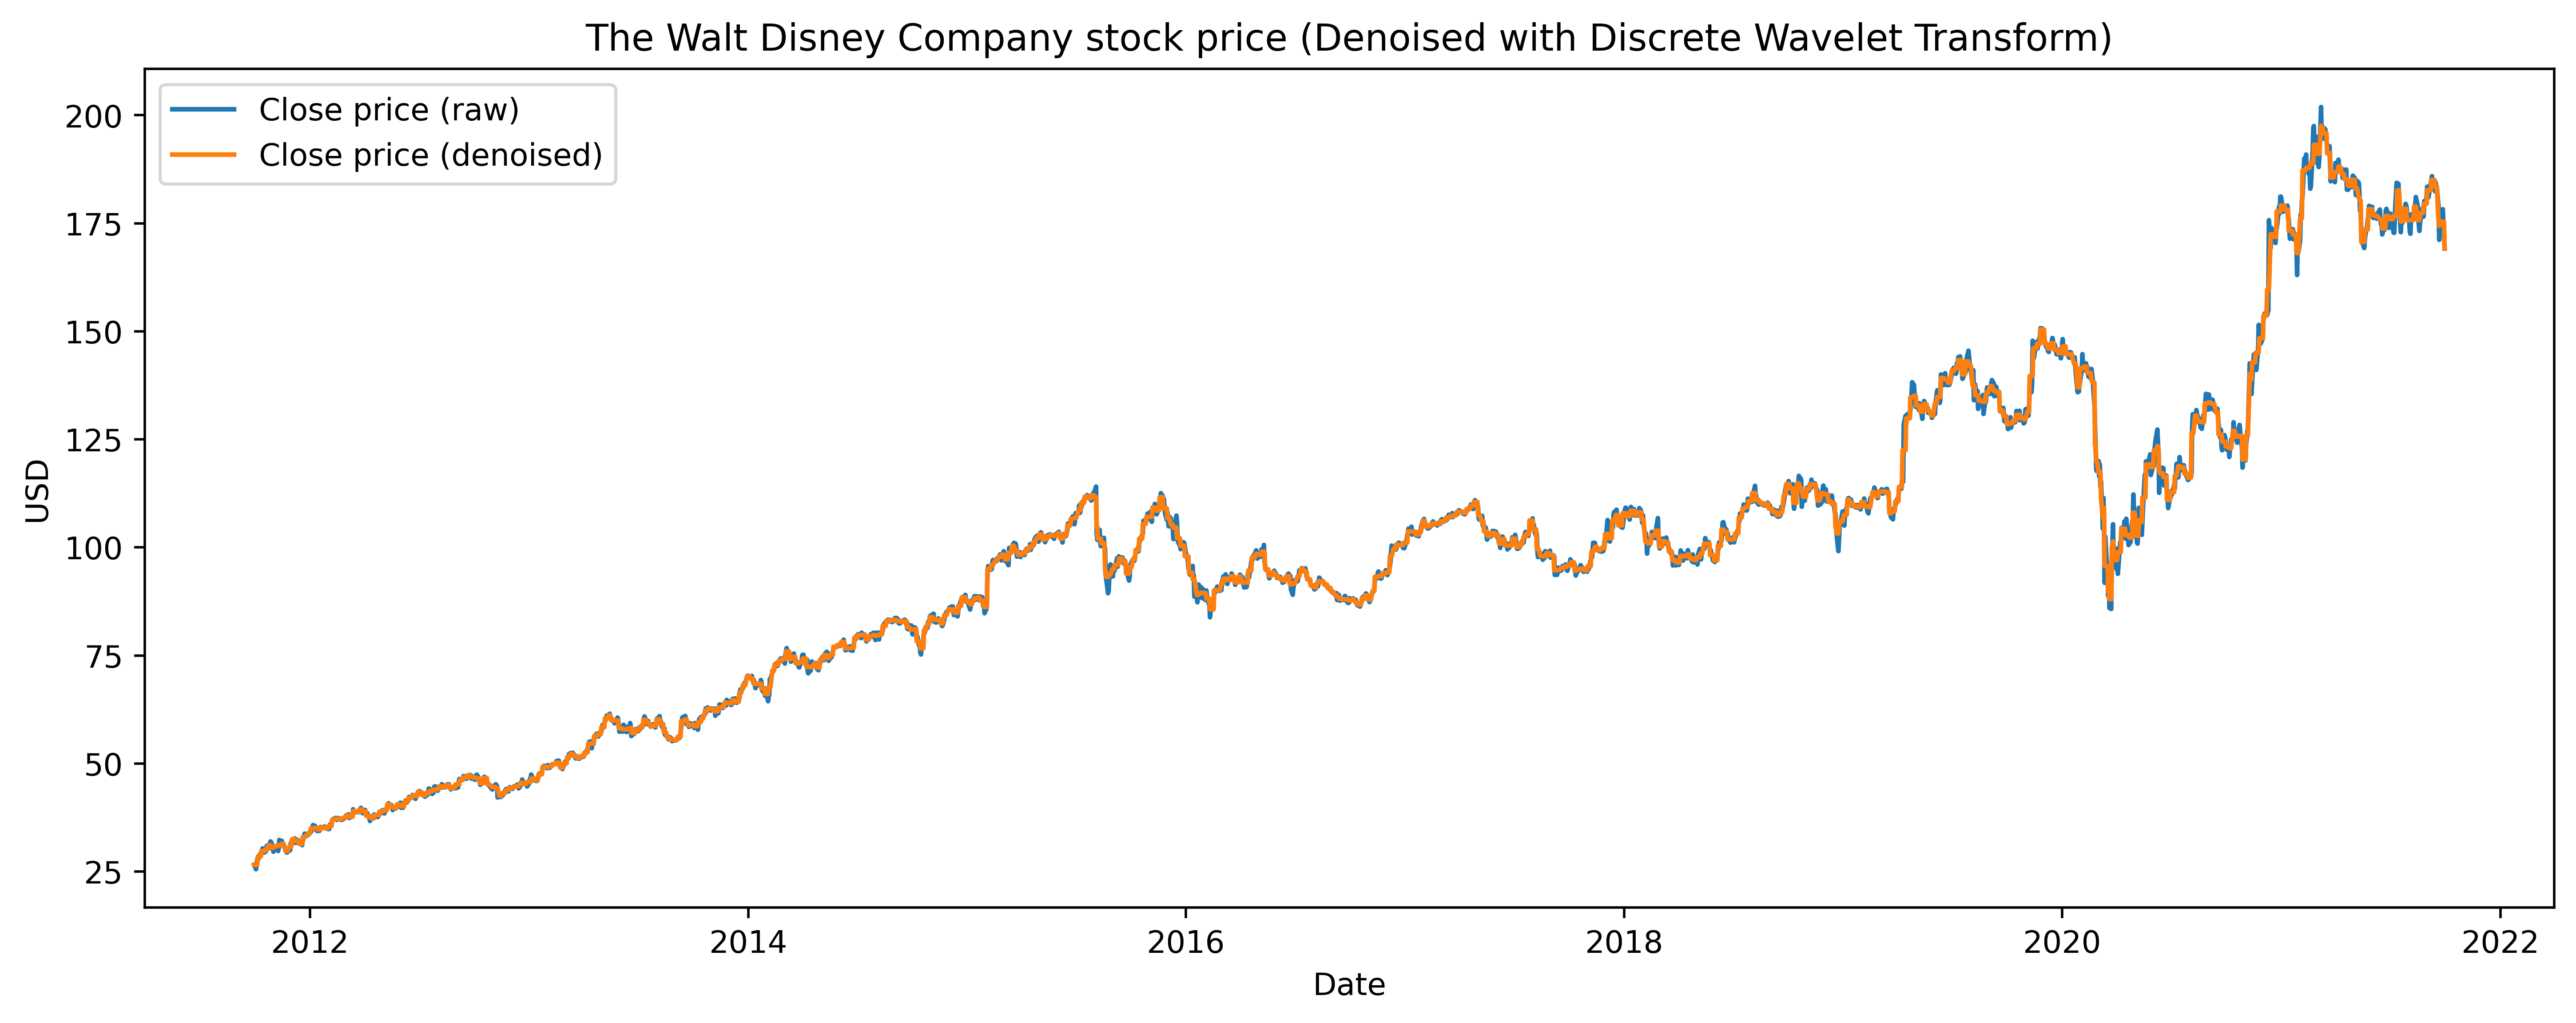

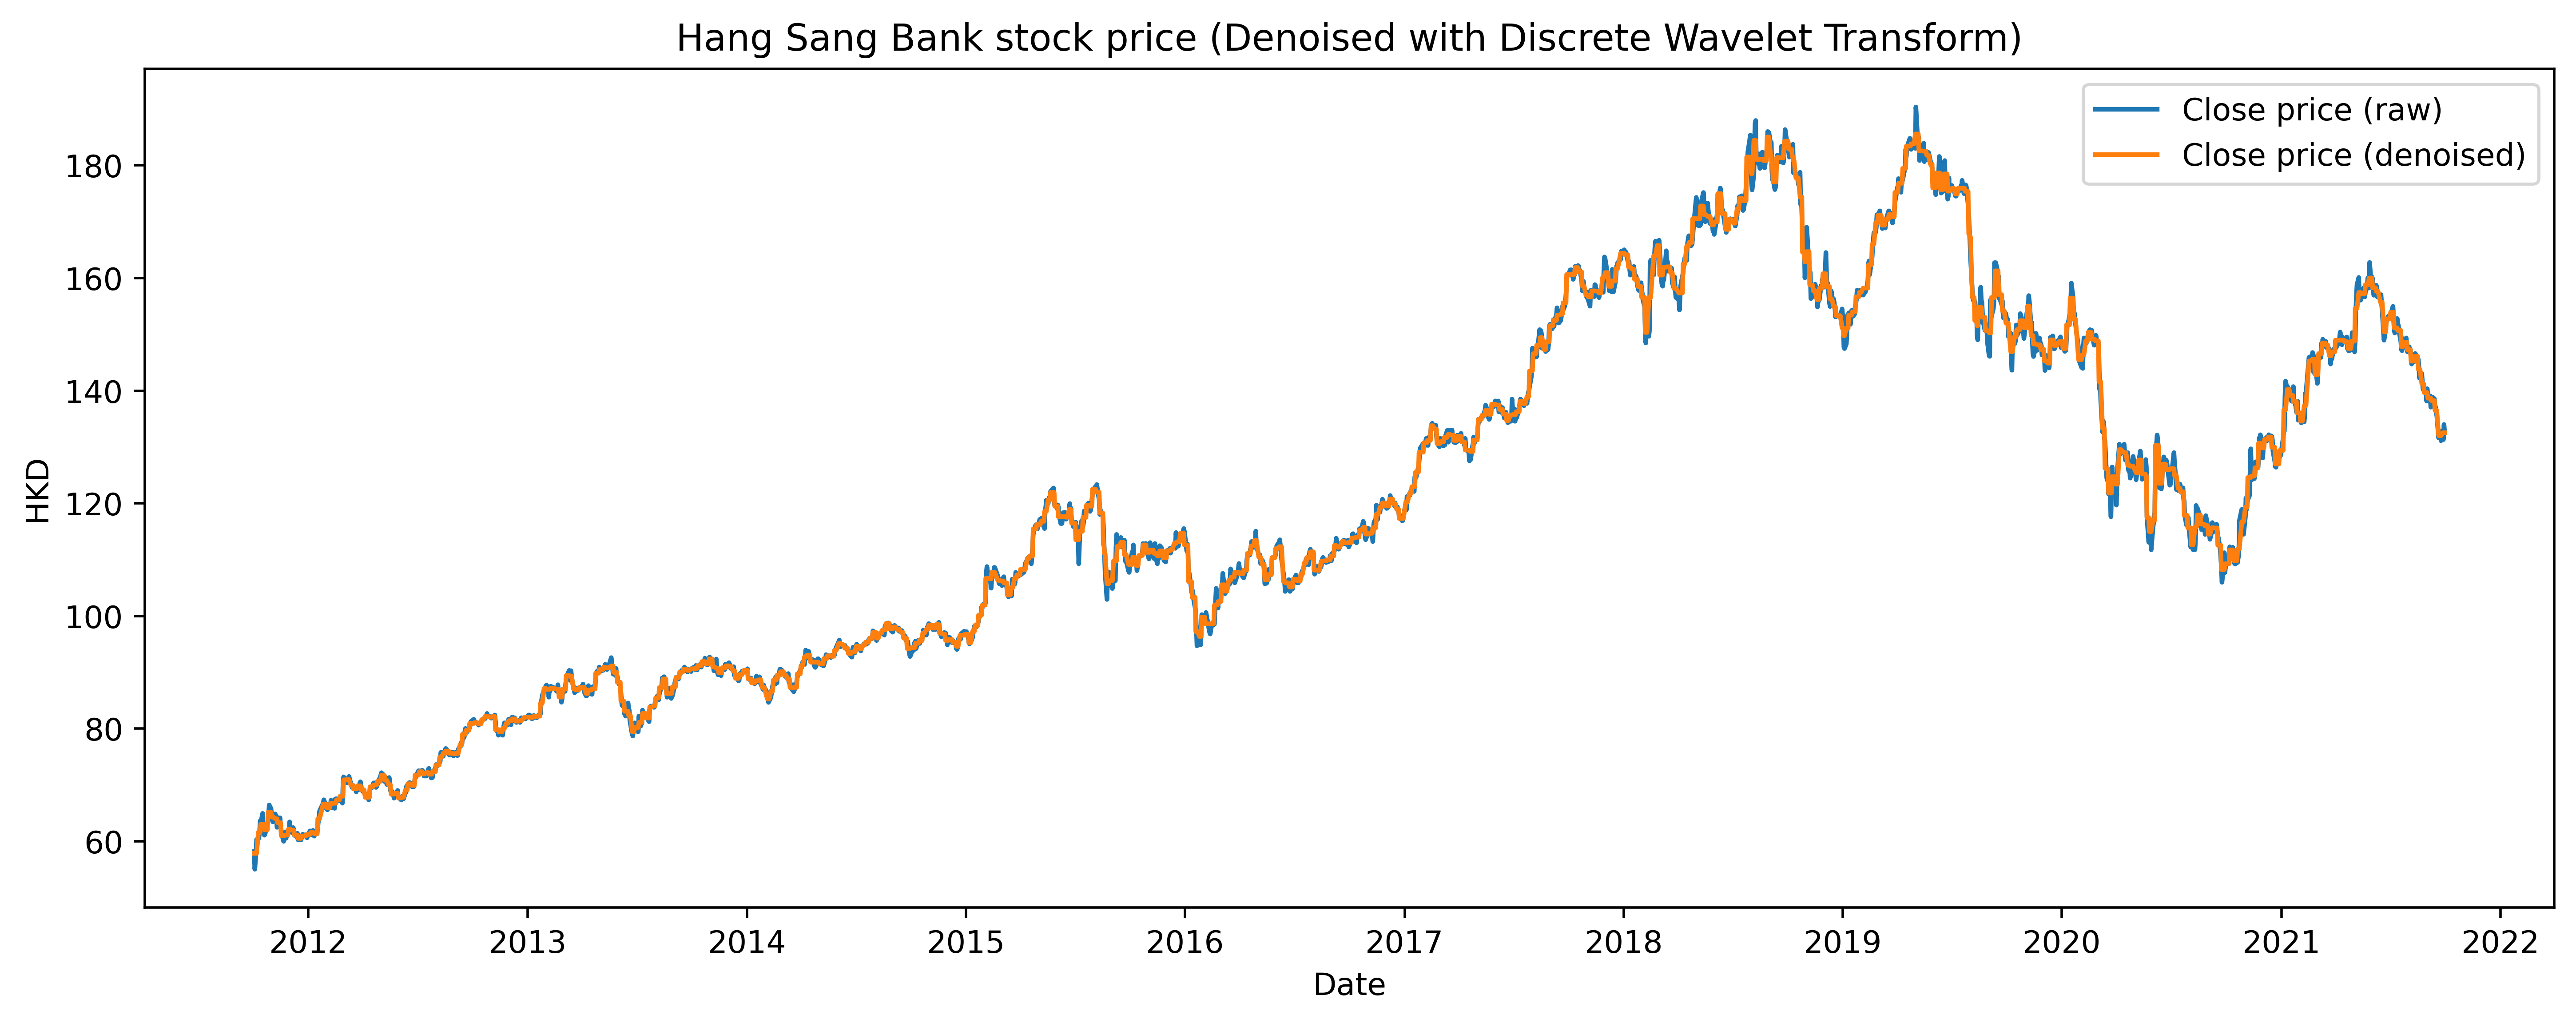

In [56]:
# plot the wavelet transformed (denoised)
def plot_wavelet_transformed_price(stock_index, title, raw_price_legend_label, denoised_price_legend_label,
                                   price_currency):
    if not isinstance(d_denoised[stock_index]["Date"][0], datetime):
        d_denoised[stock_index]["Date"] = d_denoised[stock_index]["Date"].apply(parse_string_to_datetime)

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(d[stock_index]['Date'], d[stock_index]['Close'], label=raw_price_legend_label)
    plt.plot(d_denoised[stock_index]['Date'], d_denoised[stock_index]['Close'], label=denoised_price_legend_label)
    # plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
    plt.xlabel('Date')
    plt.ylabel(price_currency)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()


# plot the wavelet transformed (denoised) of Walt Disney Stock
plot_wavelet_transformed_price("DIS",
                               'The Walt Disney Company stock price (Denoised with Discrete Wavelet Transform)',
                               'Close price (raw)',
                               "Close price (denoised)",
                               'USD'
                               )
plot_wavelet_transformed_price("0011.HK",
                               'Hang Sang Bank stock price (Denoised with Discrete Wavelet Transform)',
                               'Close price (raw)',
                               "Close price (denoised)",
                               'HKD'
                               )

### Feature Extraction
##### using the ta library https://github.com/bukosabino/ta

In [57]:
d_feat_extr = copy.deepcopy(d_denoised)  # create copy to prevent overwrite
d_feat_extr["DIS"]

Date        Open        High         Low       Close    Volume  \
0    2011-09-30   26.557592   27.041898   26.407898   26.533380  15135000   
1    2011-10-03   26.443124   26.707291   25.527344   26.533380  13899200   
2    2011-10-04   25.298400   26.390290   24.822900   26.533380  19000000   
3    2011-10-05   26.724900   27.781567   26.689677   26.533380  17823700   
4    2011-10-06   27.499790   28.221847   27.314874   28.472806  12659400   
...         ...         ...         ...         ...         ...       ...   
2512 2021-09-24  175.300003  176.699997  175.080002  175.364998   5712800   
2513 2021-09-27  176.630005  179.449997  175.960007  175.364998   7755000   
2514 2021-09-28  177.750000  178.000000  173.860001  175.364998   9133100   
2515 2021-09-29  174.250000  174.960007  172.589996  175.364998   6240800   
2516 2021-09-30  173.100006  173.679993  169.100006  169.169998  13962400   

      Dividends  Stock Splits  
0           0.0             0  
1           0.0             0  
2           0.0             0  
3           0.0             0  
4           0.0             0  
...         ...           ...  
2512        0.0             0  
2513        0.0             0  
2514        0.0             0  
2515        0.0             0  
2516        0.0             0  

[2517 rows x 8 columns]

##### Accumulation Distribution (ACD)


In [58]:
acded_count = 0
for i in range(len(fns)):
    adi_tmp = d_feat_extr[fns[i]]
    adi = AccDistIndexIndicator(
        high=adi_tmp["High"],
        low=adi_tmp["Low"],
        close=adi_tmp["Close"],
        volume=adi_tmp["Volume"],
        fillna=True
    )
    d_feat_extr[fns[i]]["ACD"] = adi.acc_dist_index()
    acded_count = acded_count + 1
    print("{} ACD OK".format(fns[i]))

print("ACD calculation finished, Count: {}".format(acded_count))


UAL ACD OK
1109.HK ACD OK
V ACD OK
2313.HK ACD OK
0027.HK ACD OK
3968.HK ACD OK
WU ACD OK
MSI ACD OK
FCX ACD OK
0003.HK ACD OK
ADM ACD OK
0011.HK ACD OK
GPN ACD OK
0857.HK ACD OK
ARE ACD OK
0001.HK ACD OK
0101.HK ACD OK
FMC ACD OK
AIZ ACD OK
BXP ACD OK
1398.HK ACD OK
0005.HK ACD OK
0941.HK ACD OK
0066.HK ACD OK
2331.HK ACD OK
0017.HK ACD OK
1093.HK ACD OK
0388.HK ACD OK
2319.HK ACD OK
0762.HK ACD OK
2628.HK ACD OK
1044.HK ACD OK
RL ACD OK
0241.HK ACD OK
FTNT ACD OK
JNPR ACD OK
DHI ACD OK
2020.HK ACD OK
EXPE ACD OK
1928.HK ACD OK
KO ACD OK
WDC ACD OK
LUMN ACD OK
UPS ACD OK
MSFT ACD OK
UDR ACD OK
COO ACD OK
2018.HK ACD OK
MLM ACD OK
0267.HK ACD OK
AMD ACD OK
ZBH ACD OK
0386.HK ACD OK
UHS ACD OK
SBAC ACD OK
0002.HK ACD OK
0669.HK ACD OK
LKQ ACD OK
PVH ACD OK
3988.HK ACD OK
GD ACD OK
CLX ACD OK
0688.HK ACD OK
DIS ACD OK
0883.HK ACD OK
LDOS ACD OK
LEN ACD OK
2382.HK ACD OK
AOS ACD OK
OMC ACD OK
1299.HK ACD OK
TSLA ACD OK
TXT ACD OK
1177.HK ACD OK
0012.HK ACD OK
0939.HK ACD OK
0960.HK ACD OK

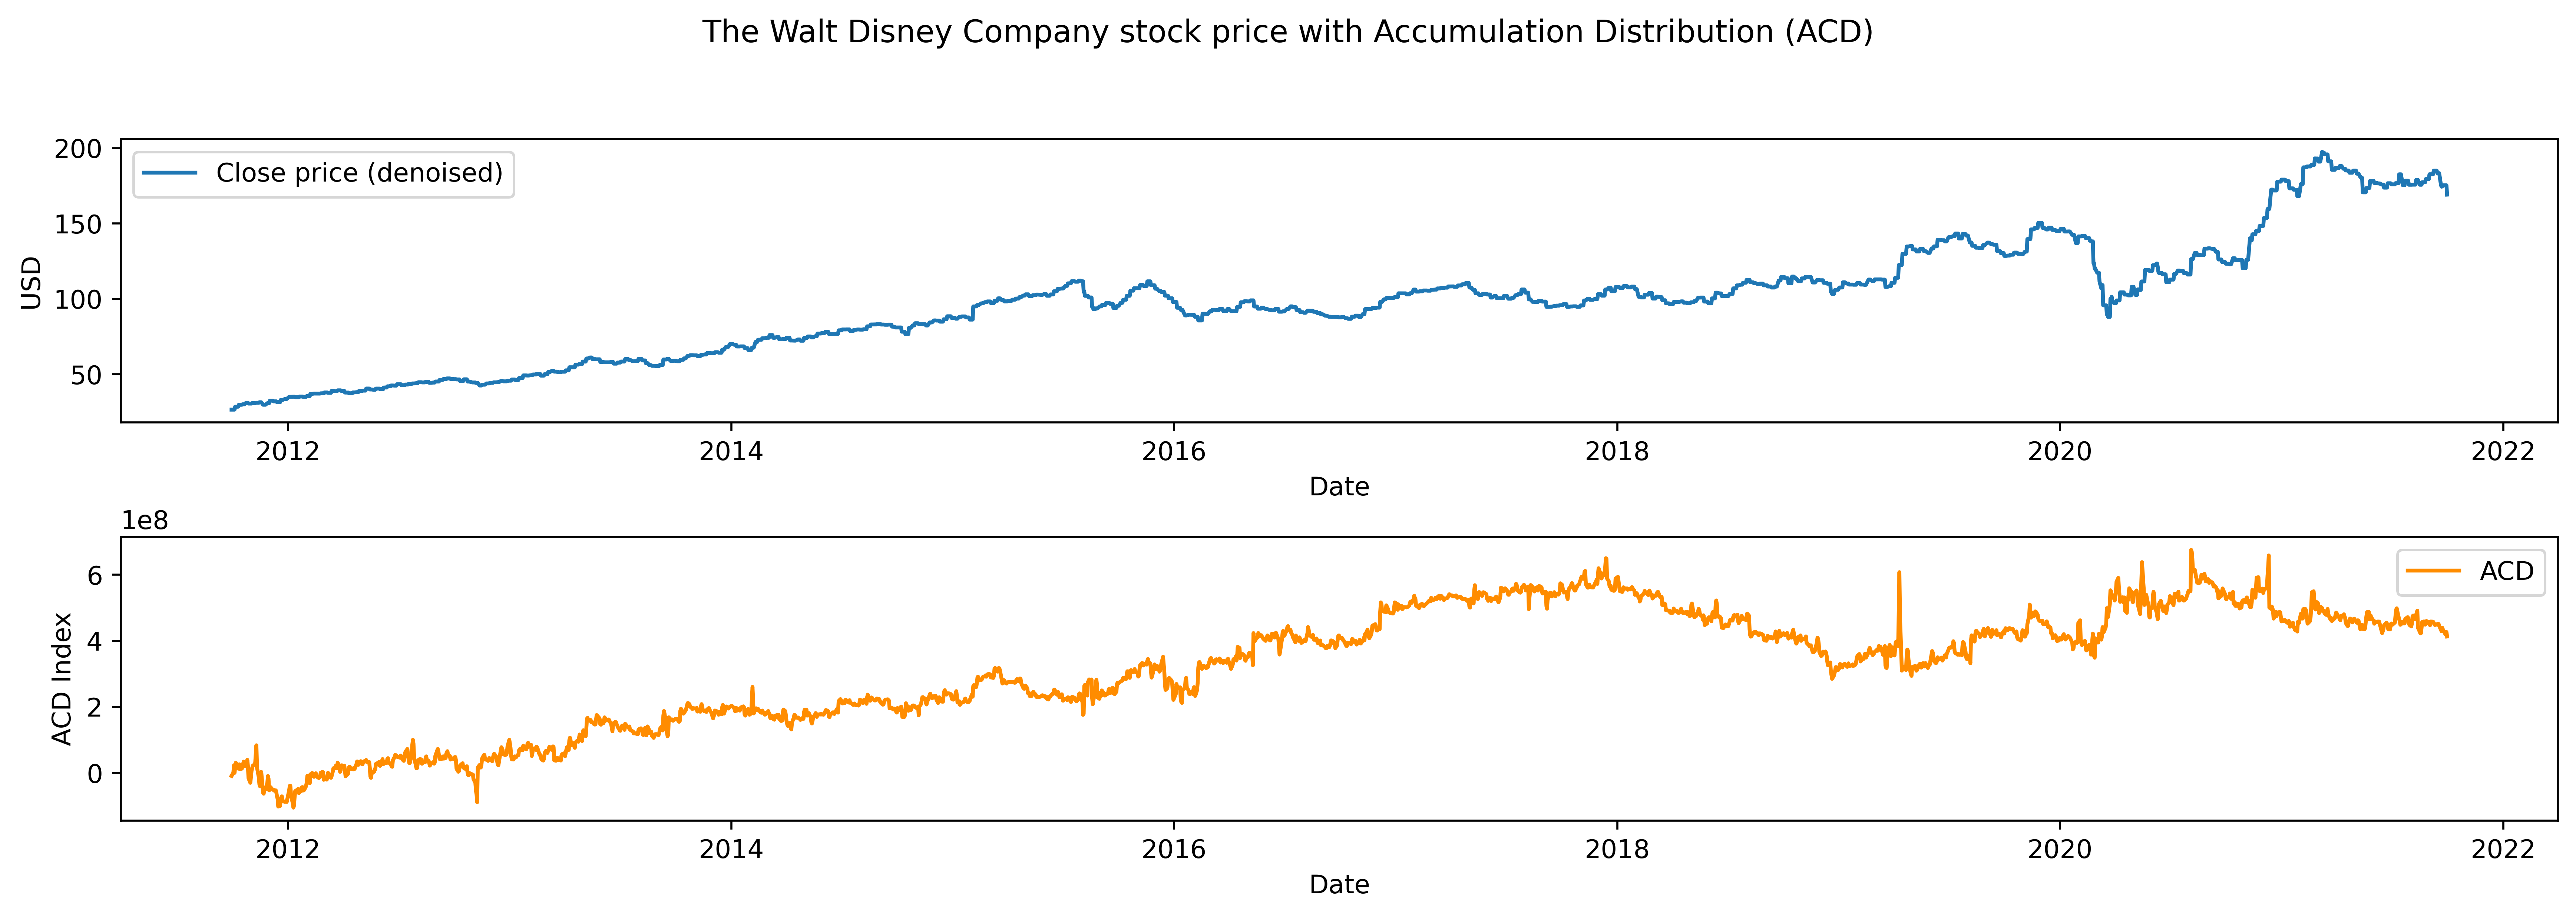

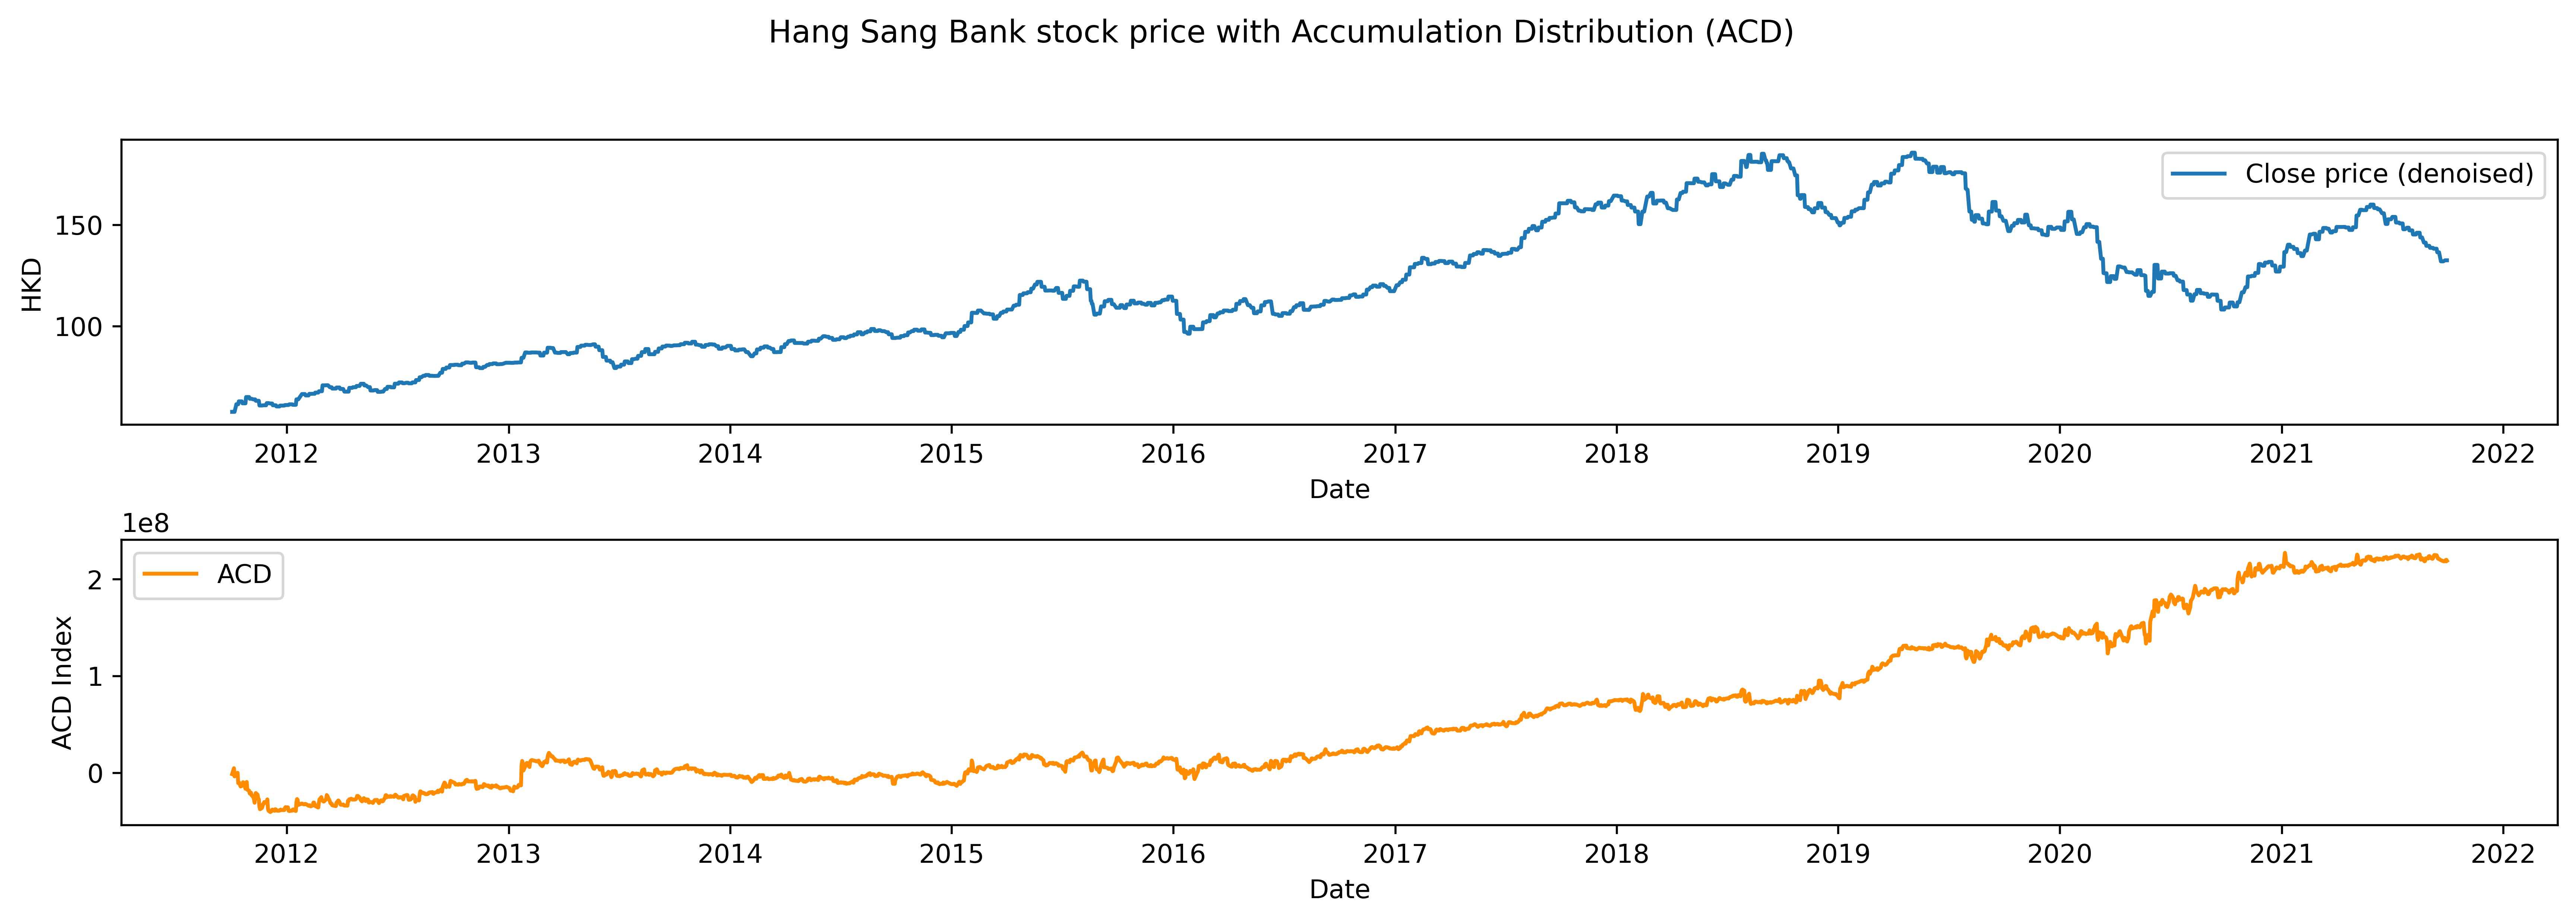

In [59]:
# plot Accumulation Distribution (ACD) line plots
def plot_acd_index(stock_id, plot_title, stock_price_legend_label, acd_legend_label, price_currency):
    if not isinstance(d_feat_extr[stock_id]["Date"][0], datetime):
        d_feat_extr[stock_id]["Date"] = d_feat_extr[stock_id]["Date"].apply(parse_string_to_datetime)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 5), dpi=500, facecolor="white")
    ax1.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['Close'], label=stock_price_legend_label)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(price_currency)
    ax1.legend()

    ax2.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['ACD'], label=acd_legend_label, color="darkorange")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('ACD Index')
    ax2.legend()

    fig.tight_layout()
    fig.suptitle(plot_title)
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.subplots_adjust(top=0.85)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, fig._suptitle.get_text()))
    plt.show()


plot_acd_index("DIS",
               "The Walt Disney Company stock price with Accumulation Distribution (ACD)",
               'Close price (denoised)',
               'ACD',
               'USD'
               )
plot_acd_index("0011.HK",
               "Hang Sang Bank stock price with Accumulation Distribution (ACD)",
               'Close price (denoised)',
               'ACD',
               'HKD'
               )

##### Moving Average Convergence Divergence (MACD)

In [60]:
macd_count = 0
for i in range(len(fns)):
    macd_tmp = d_feat_extr[fns[i]]
    macd_instance = MACD(
        close=macd_tmp["Close"],
        fillna=True
    )
    #MACD line
    d_feat_extr[fns[i]]["MACD"] = macd_instance.macd()

    #MACD signal line
    d_feat_extr[fns[i]]["MACD_SIGNAL"] = macd_instance.macd_signal()

    #MACD Diff
    d_feat_extr[fns[i]]["MACD_DIFF"] = macd_instance.macd_diff()

    macd_count = macd_count + 1
    print("{} MACD OK".format(fns[i]))

print("MACD calculation finished, Count: {}".format(macd_count))


UAL MACD OK
1109.HK MACD OK
V MACD OK
2313.HK MACD OK
0027.HK MACD OK
3968.HK MACD OK
WU MACD OK
MSI MACD OK
FCX MACD OK
0003.HK MACD OK
ADM MACD OK
0011.HK MACD OK
GPN MACD OK
0857.HK MACD OK
ARE MACD OK
0001.HK MACD OK
0101.HK MACD OK
FMC MACD OK
AIZ MACD OK
BXP MACD OK
1398.HK MACD OK
0005.HK MACD OK
0941.HK MACD OK
0066.HK MACD OK
2331.HK MACD OK
0017.HK MACD OK
1093.HK MACD OK
0388.HK MACD OK
2319.HK MACD OK
0762.HK MACD OK
2628.HK MACD OK
1044.HK MACD OK
RL MACD OK
0241.HK MACD OK
FTNT MACD OK
JNPR MACD OK
DHI MACD OK
2020.HK MACD OK
EXPE MACD OK
1928.HK MACD OK
KO MACD OK
WDC MACD OK
LUMN MACD OK
UPS MACD OK
MSFT MACD OK
UDR MACD OK
COO MACD OK
2018.HK MACD OK
MLM MACD OK
0267.HK MACD OK
AMD MACD OK
ZBH MACD OK
0386.HK MACD OK
UHS MACD OK
SBAC MACD OK
0002.HK MACD OK
0669.HK MACD OK
LKQ MACD OK
PVH MACD OK
3988.HK MACD OK
GD MACD OK
CLX MACD OK
0688.HK MACD OK
DIS MACD OK
0883.HK MACD OK
LDOS MACD OK
LEN MACD OK
2382.HK MACD OK
AOS MACD OK
OMC MACD OK
1299.HK MACD OK
TSLA MACD O

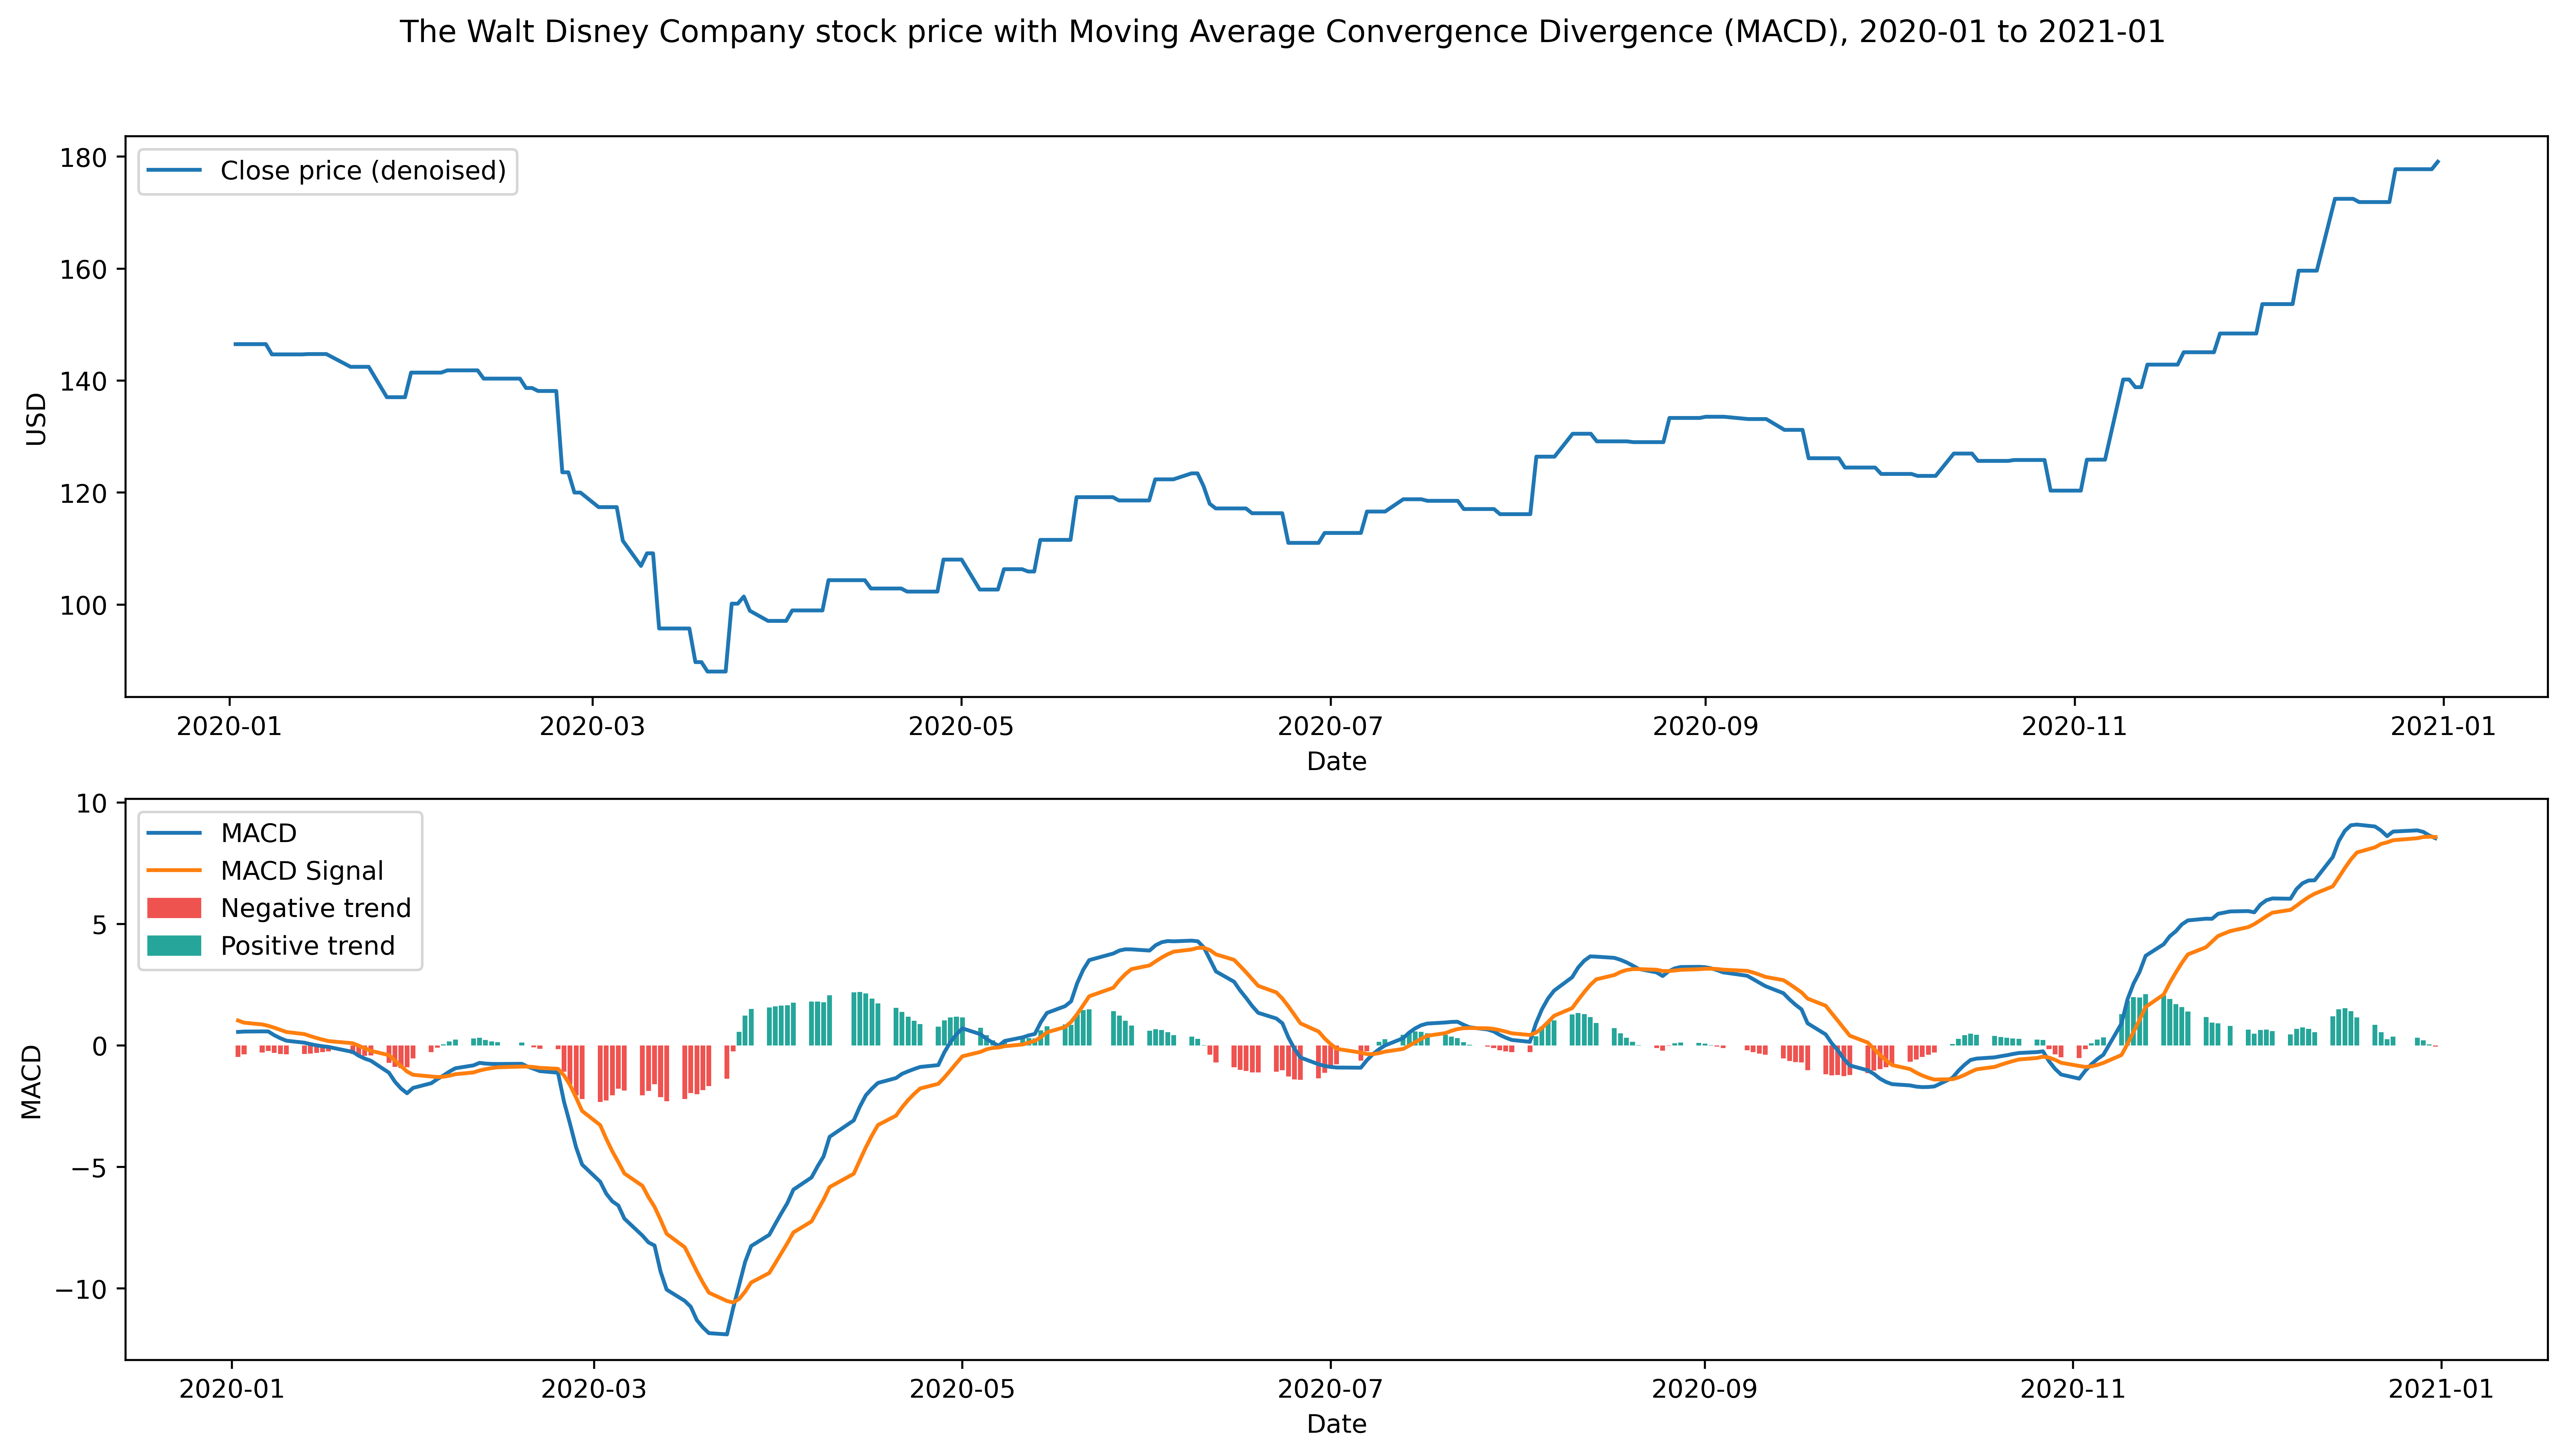

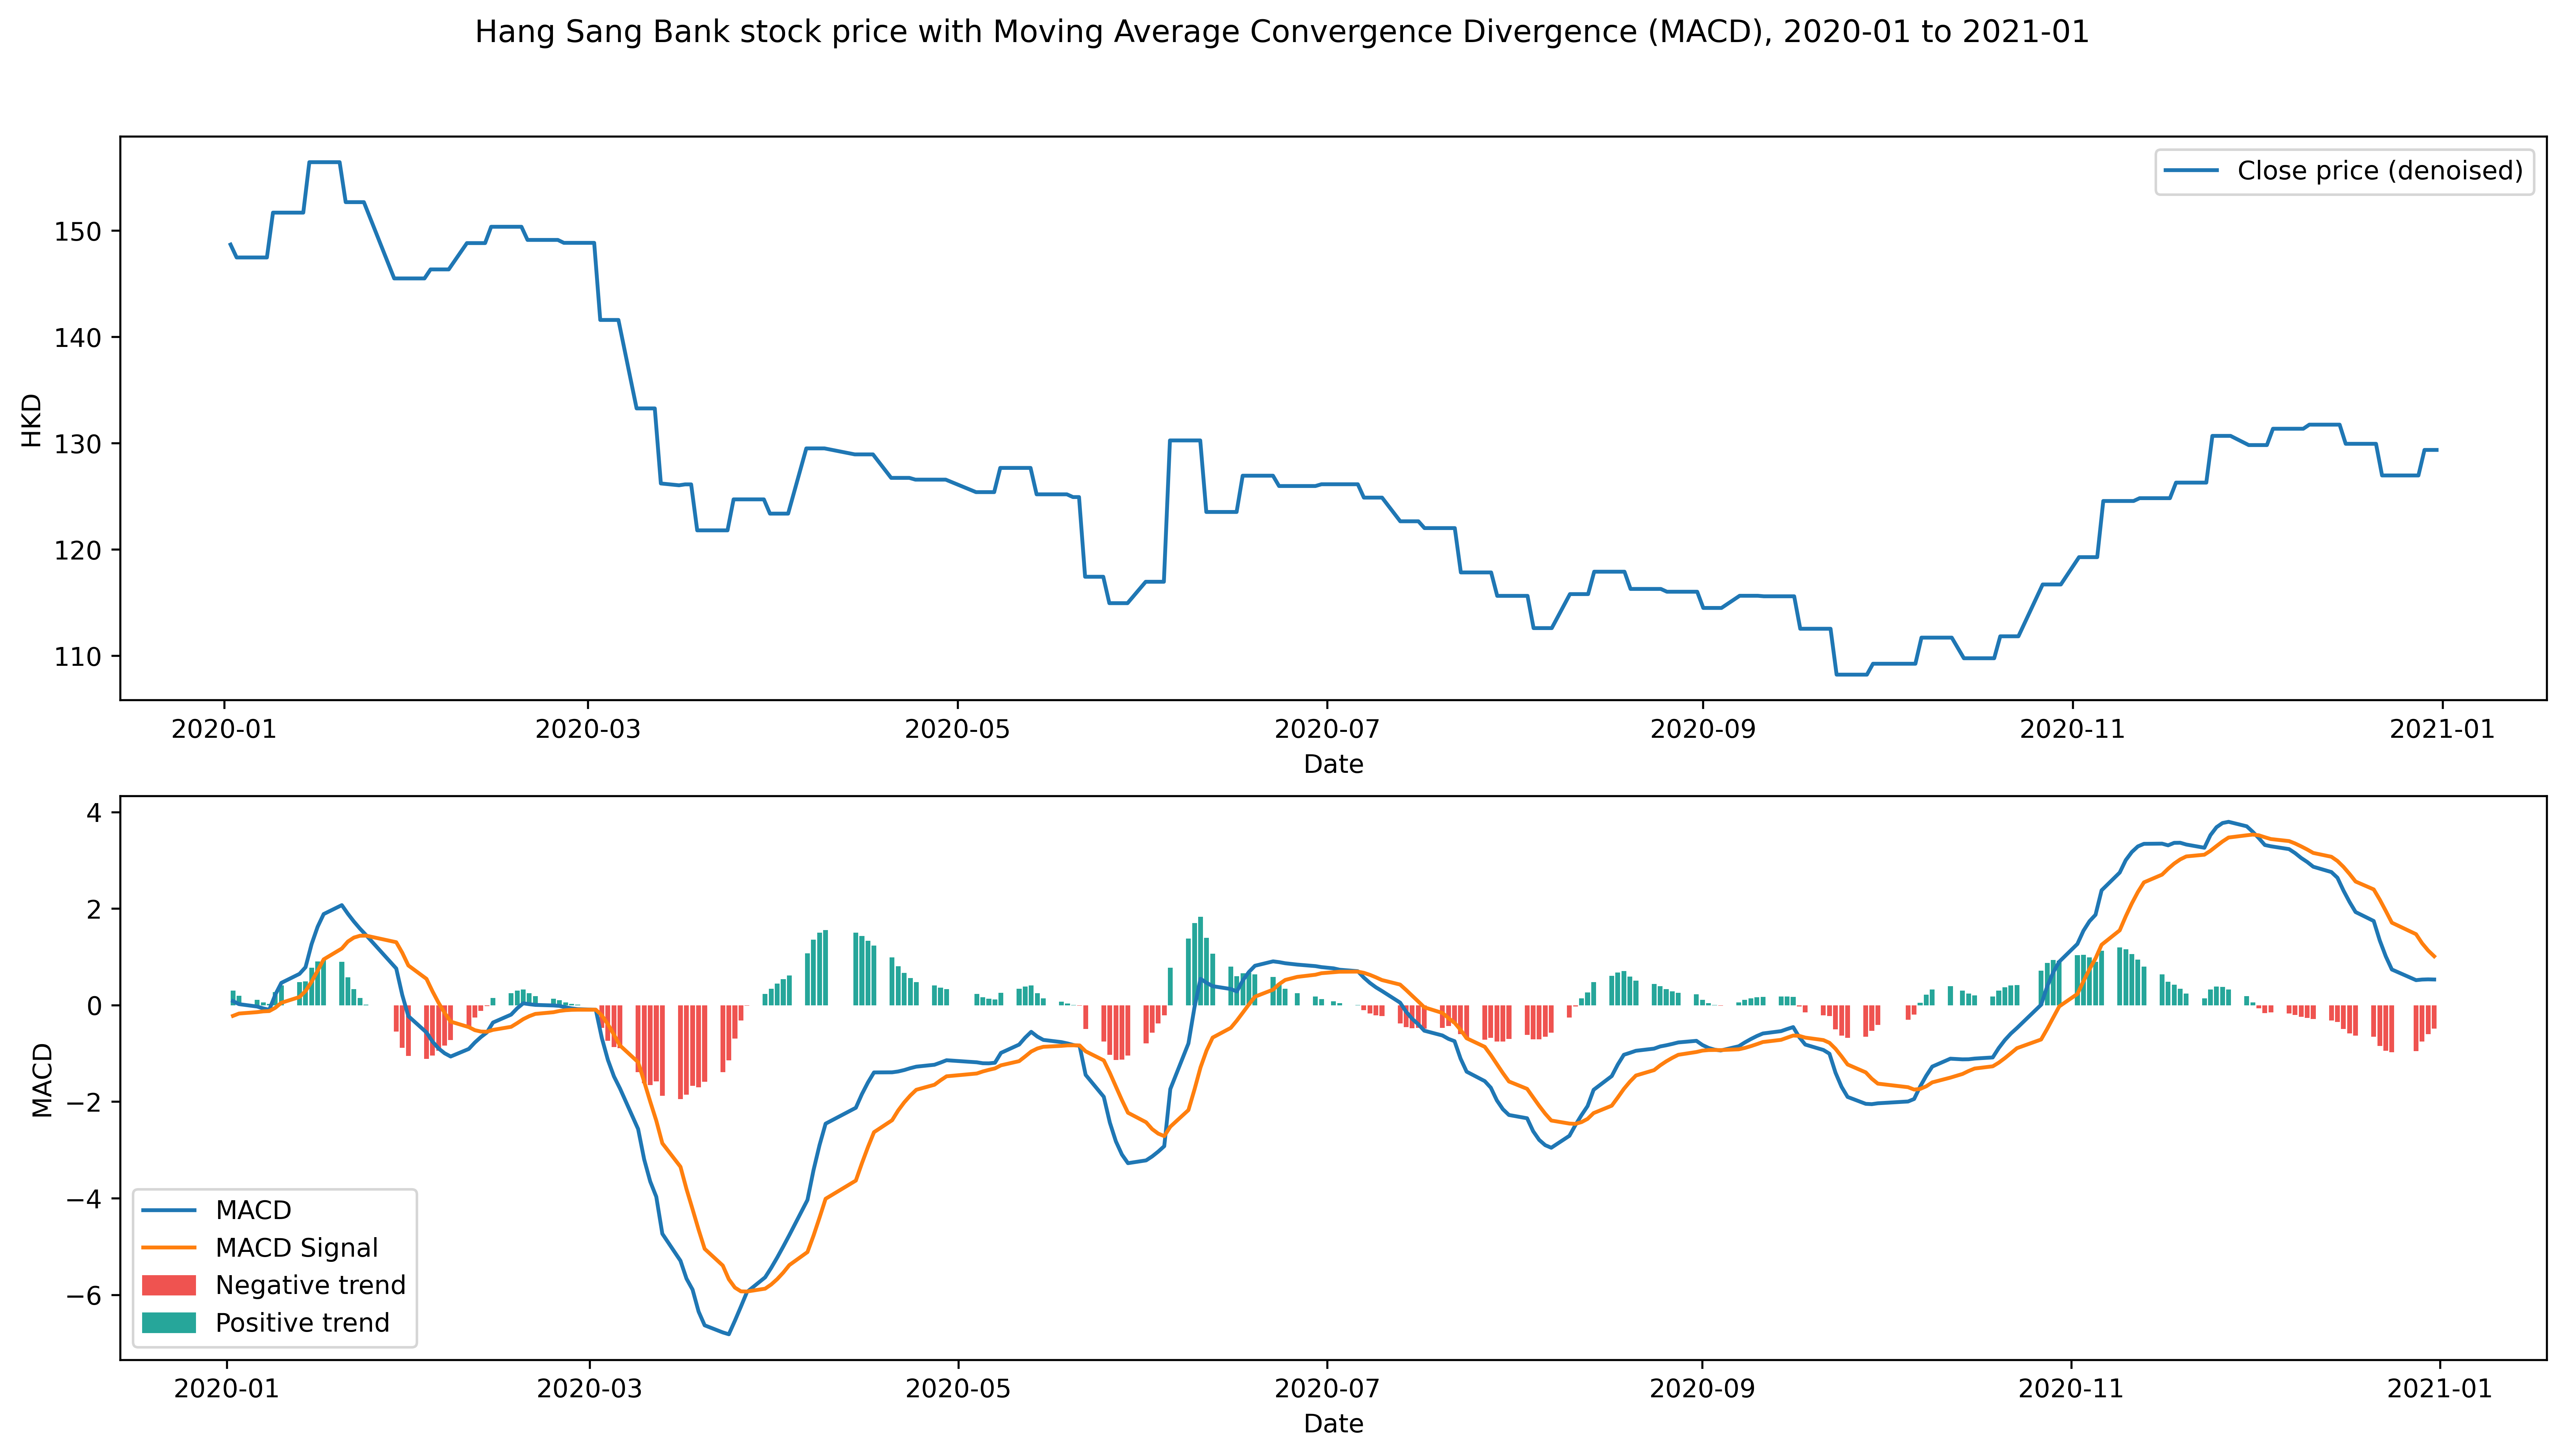

In [61]:
# plot MACD, MACD Signal lines, and histogram for MACD diff
def plot_macd_index(stock_id, plot_title, stock_price_legend_label, price_currency,
                    macd_legend_label, macd_signal_legend_label, macd_diff_legend_label,
                    start_date=datetime(2020, 1, 1, hour=0), end_date=datetime(2021, 1, 1, hour=0)):
    if not isinstance(d_feat_extr[stock_id]["Date"][0], datetime):
        d_feat_extr[stock_id]["Date"] = d_feat_extr[stock_id]["Date"].apply(parse_string_to_datetime)

    d_feat_tmp = d_feat_extr[stock_id]\
        [(d_feat_extr[stock_id]['Date']>start_date) \
         & (d_feat_extr[stock_id]['Date']<end_date)]

    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 8), dpi=500, facecolor="white")
    ax1.plot(d_feat_tmp['Date'], d_feat_tmp['Close'], label=stock_price_legend_label)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(price_currency)
    ax1.legend()

    ax2.plot(d_feat_tmp['Date'], d_feat_tmp['MACD'], label=macd_legend_label)
    ax2.plot(d_feat_tmp['Date'], d_feat_tmp['MACD_SIGNAL'], label=macd_signal_legend_label)
    # plot box plot on the diagram, ref: https://medium.com/codex/algorithmic-trading-with-macd-in-python-1c2769a6ad1b
    for k in range(len(d_feat_tmp['MACD_DIFF'])):
        if d_feat_tmp['MACD_DIFF'].iloc[k] < 0:
            ax2.bar(d_feat_tmp['Date'].iloc[k], d_feat_tmp['MACD_DIFF'].iloc[k], color="#ef5350")
        else:
            ax2.bar(d_feat_tmp['Date'].iloc[k], d_feat_tmp['MACD_DIFF'].iloc[k], color="#26a69a")

    ax2.set_xlabel('Date')
    ax2.set_ylabel('MACD')
    # add custom legend labels: ref https://stackoverflow.com/a/56551701/9500852
    negative_patch = mpatches.Patch(color='#26a69a', label='Positive trend')
    positive_patch = mpatches.Patch(color='#ef5350', label='Negative trend')
    ax2_handles, ax2_labels = ax2.get_legend_handles_labels()
    ax2_handles = ax2_handles + [positive_patch] + [negative_patch]
    ax2.legend(handles=ax2_handles)

    fig.tight_layout()
    fig.suptitle(plot_title.format(start_date.strftime("%Y-%m"), end_date.strftime("%Y-%m")))
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.subplots_adjust(top=0.9)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, fig._suptitle.get_text()))
    plt.show()


plot_macd_index("DIS",
                "The Walt Disney Company stock price with Moving Average Convergence Divergence (MACD), {} to {}",
                'Close price (denoised)',
                'USD',
                'MACD',
                'MACD Signal',
                'MACD DIFF'
                )

plot_macd_index("0011.HK",
                "Hang Sang Bank stock price with Moving Average Convergence Divergence (MACD), {} to {}",
                'Close price (denoised)',
                'HKD',
                'MACD',
                'MACD Signal',
                'MACD DIFF'
                )

##### On-balance Volume (OBV)

In [62]:
obv_count = 0
for i in range(len(fns)):
    obv_tmp = d_feat_extr[fns[i]]
    obv_instance = OnBalanceVolumeIndicator(
        close=obv_tmp["Close"],
        volume=obv_tmp["Volume"],
        fillna=True
    )

    # calc obv
    d_feat_extr[fns[i]]["OBV"] =  obv_instance.on_balance_volume()
    obv_count = obv_count + 1
    print("{} OBV OK".format(fns[i]))

print("OBV calculation finished, Count: {}".format(obv_count))

UAL OBV OK
1109.HK OBV OK
V OBV OK
2313.HK OBV OK
0027.HK OBV OK
3968.HK OBV OK
WU OBV OK
MSI OBV OK
FCX OBV OK
0003.HK OBV OK
ADM OBV OK
0011.HK OBV OK
GPN OBV OK
0857.HK OBV OK
ARE OBV OK
0001.HK OBV OK
0101.HK OBV OK
FMC OBV OK
AIZ OBV OK
BXP OBV OK
1398.HK OBV OK
0005.HK OBV OK
0941.HK OBV OK
0066.HK OBV OK
2331.HK OBV OK
0017.HK OBV OK
1093.HK OBV OK
0388.HK OBV OK
2319.HK OBV OK
0762.HK OBV OK
2628.HK OBV OK
1044.HK OBV OK
RL OBV OK
0241.HK OBV OK
FTNT OBV OK
JNPR OBV OK
DHI OBV OK
2020.HK OBV OK
EXPE OBV OK
1928.HK OBV OK
KO OBV OK
WDC OBV OK
LUMN OBV OK
UPS OBV OK
MSFT OBV OK
UDR OBV OK
COO OBV OK
2018.HK OBV OK
MLM OBV OK
0267.HK OBV OK
AMD OBV OK
ZBH OBV OK
0386.HK OBV OK
UHS OBV OK
SBAC OBV OK
0002.HK OBV OK
0669.HK OBV OK
LKQ OBV OK
PVH OBV OK
3988.HK OBV OK
GD OBV OK
CLX OBV OK
0688.HK OBV OK
DIS OBV OK
0883.HK OBV OK
LDOS OBV OK
LEN OBV OK
2382.HK OBV OK
AOS OBV OK
OMC OBV OK
1299.HK OBV OK
TSLA OBV OK
TXT OBV OK
1177.HK OBV OK
0012.HK OBV OK
0939.HK OBV OK
0960.HK OBV OK

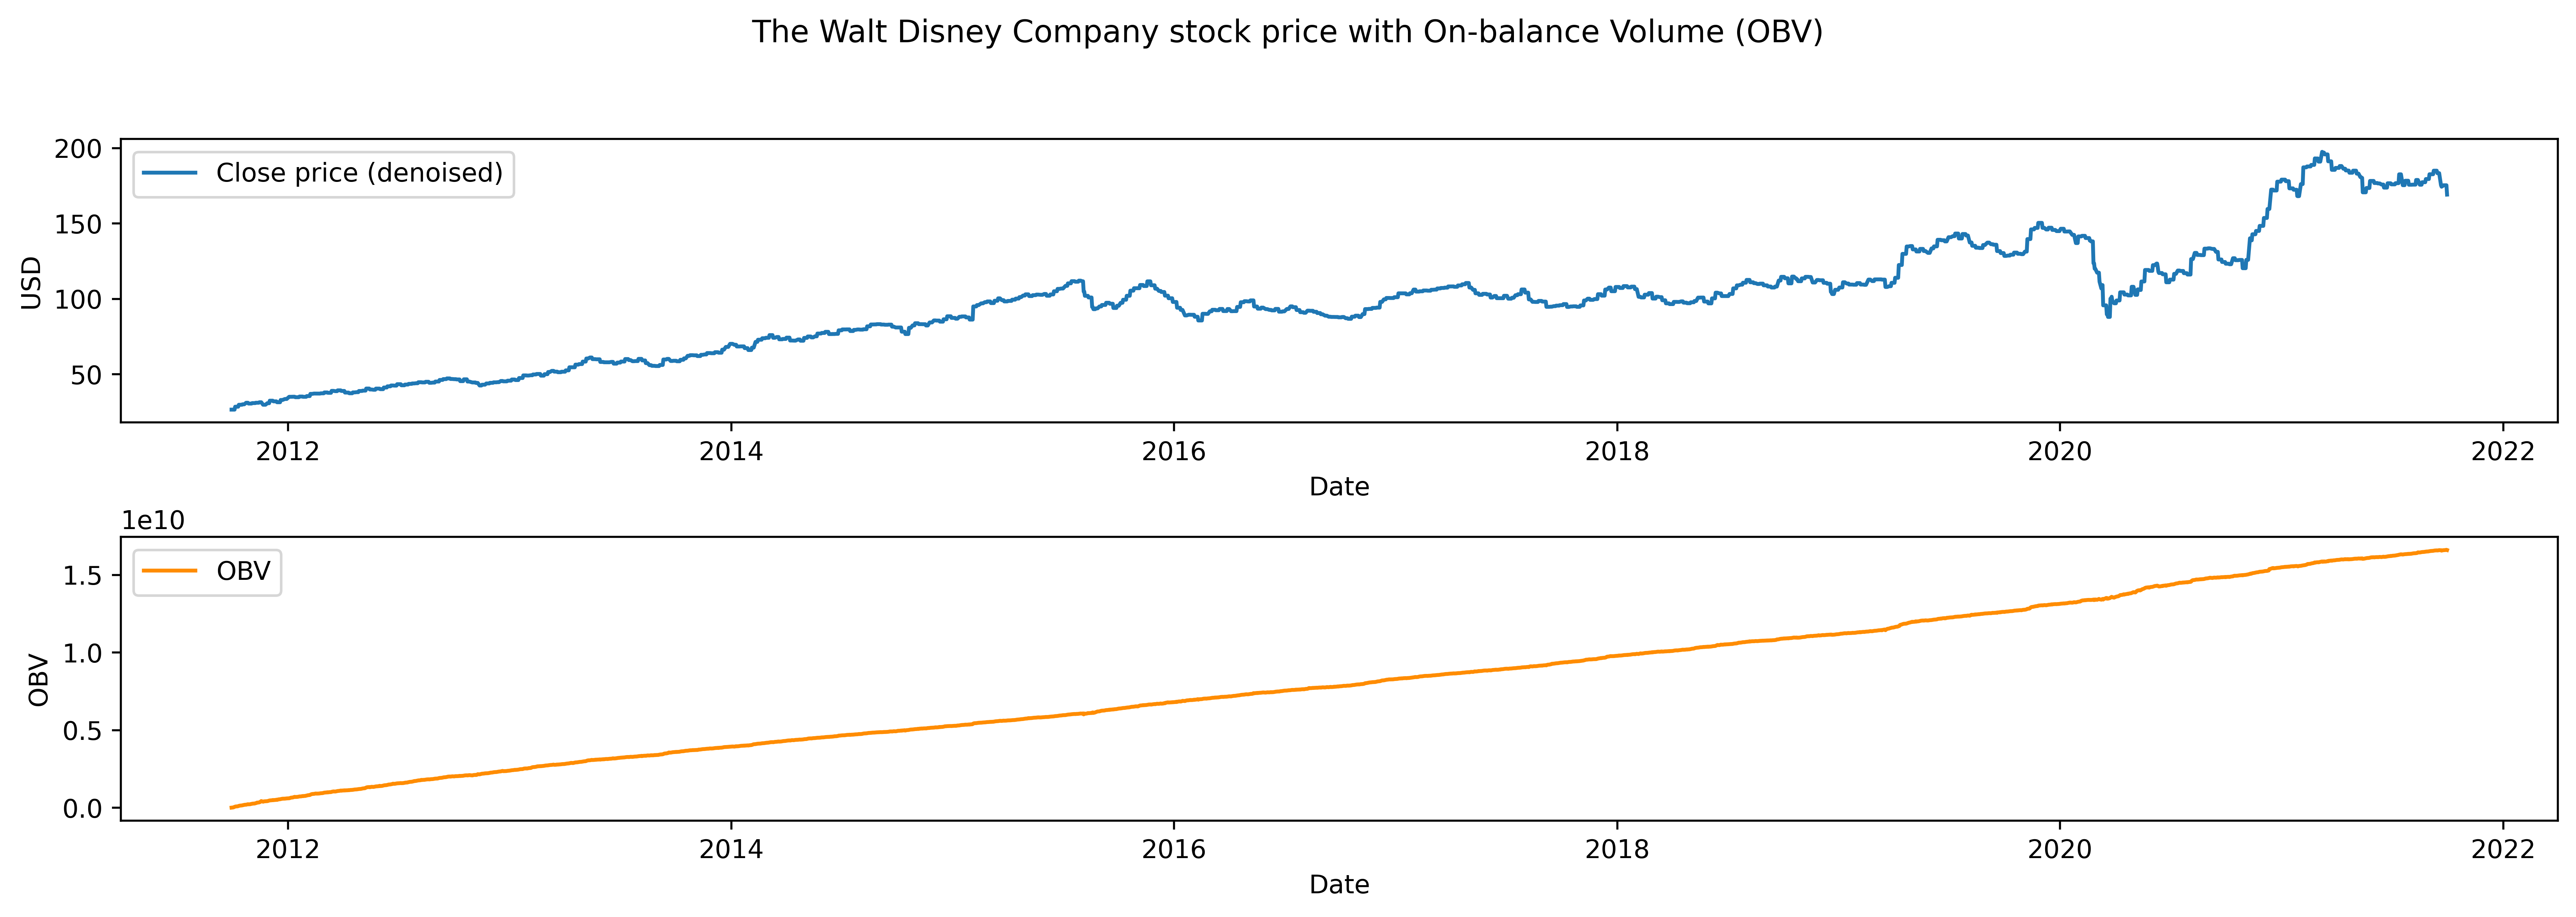

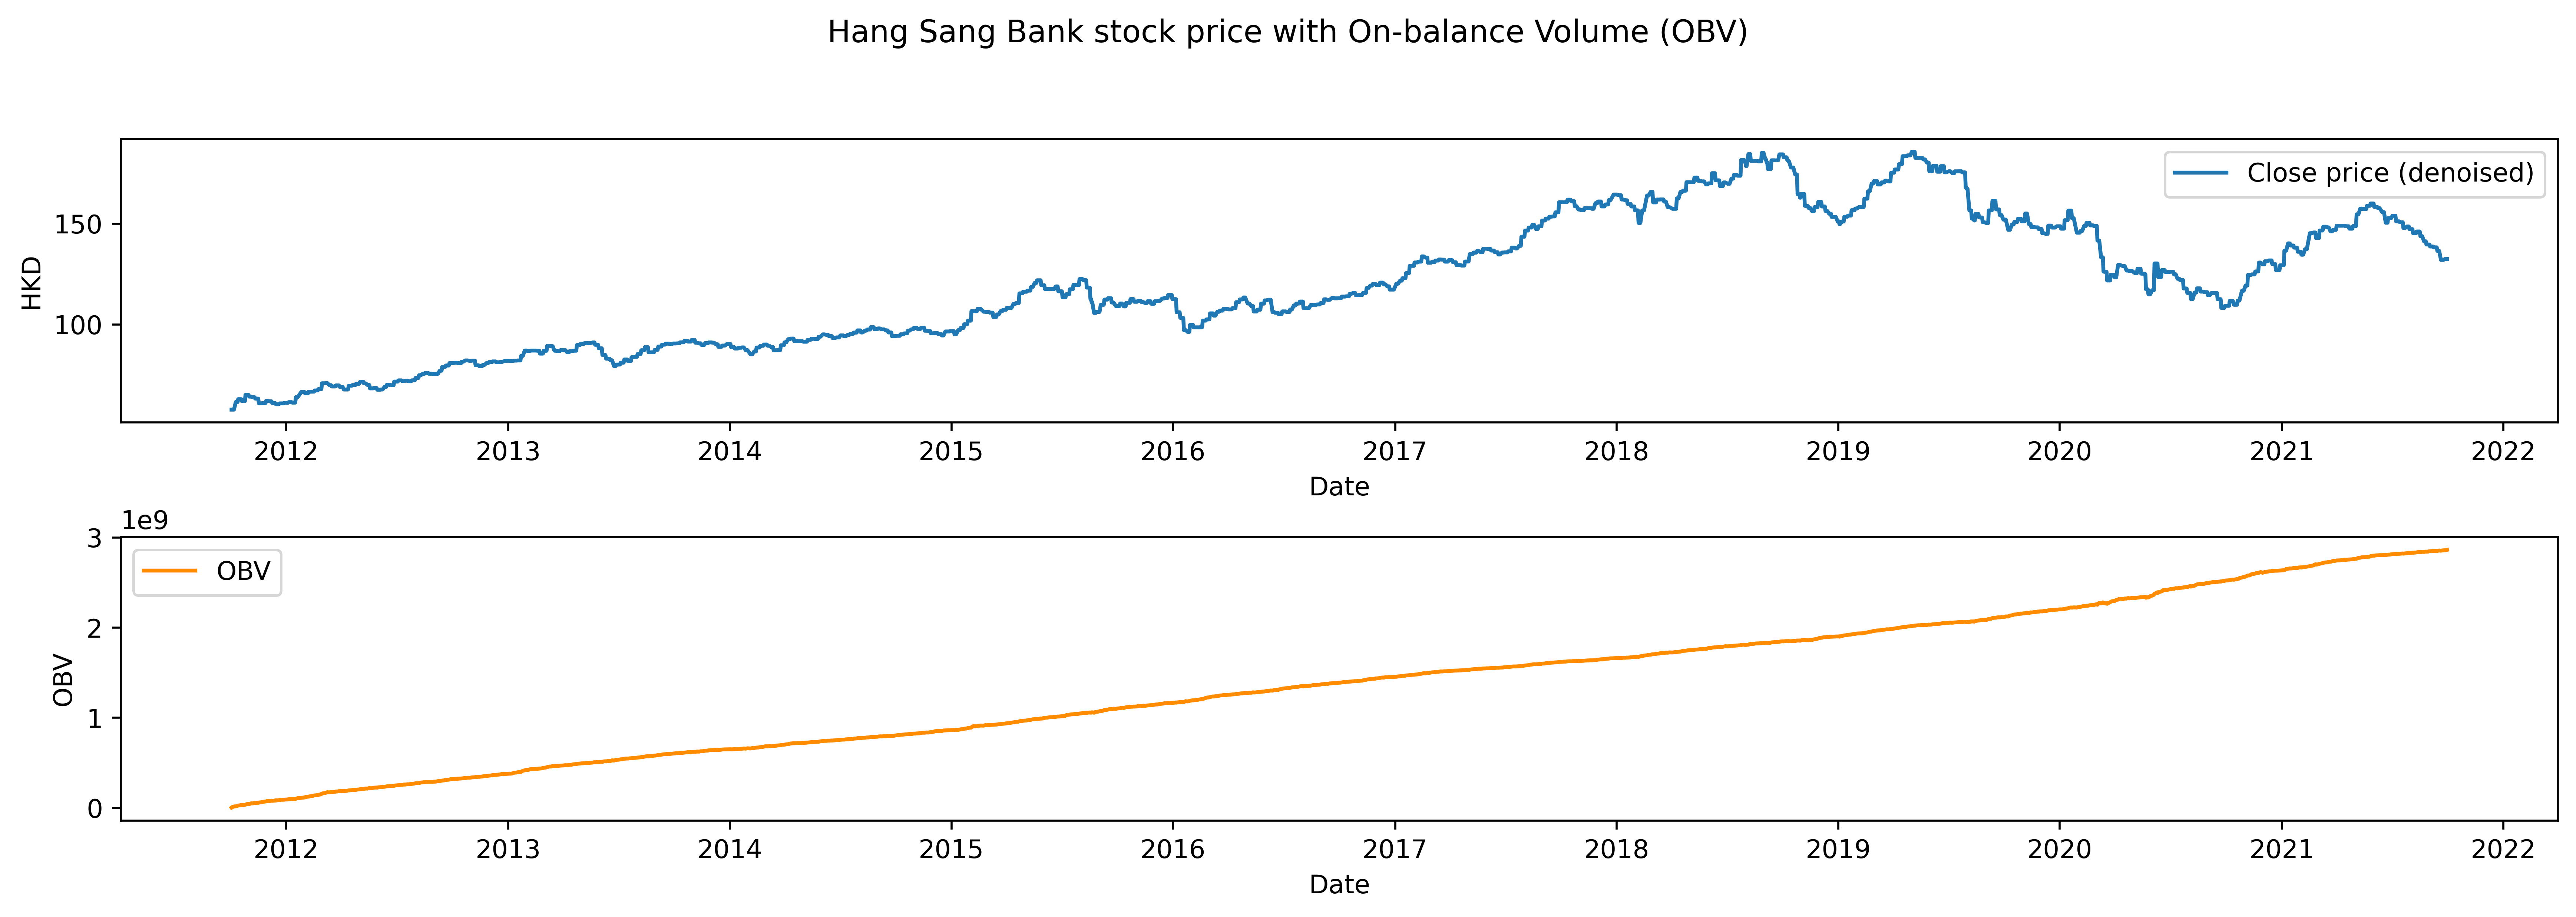

In [63]:
# Plot OBV
def plot_obv_index(stock_id, plot_title,
             stock_price_legend_label, obv_legend_label, price_currency):
    if not isinstance(d_feat_extr[stock_id]["Date"][0], datetime):
        d_feat_extr[stock_id]["Date"] = d_feat_extr[stock_id]["Date"].apply(parse_string_to_datetime)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 5), dpi=500, facecolor="white")
    ax1.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['Close'], label=stock_price_legend_label)
    ax1.set_xlabel('Date')
    ax1.set_ylabel(price_currency)
    ax1.legend()

    ax2.plot(d_feat_extr[stock_id]['Date'], d_feat_extr[stock_id]['OBV'], label=obv_legend_label, color="darkorange")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('OBV')
    ax2.legend()

    fig.tight_layout()
    fig.suptitle(plot_title)
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.subplots_adjust(top=0.85)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, fig._suptitle.get_text()))
    plt.show()

plot_obv_index("DIS",
               "The Walt Disney Company stock price with On-balance Volume (OBV)",
               'Close price (denoised)',
               'OBV',
               'USD'
               )

plot_obv_index("0011.HK",
               "Hang Sang Bank stock price with On-balance Volume (OBV)",
               'Close price (denoised)',
               'OBV',
               'HKD'
               )

##### The upper, middle, and lower band of the Bollinger Bands


In [64]:
bb_count = 0
for i in range(len(fns)):
    bb_tmp = d_feat_extr[fns[i]]
    bb_instance = BollingerBands(
        close=bb_tmp[["High", "Close", "Low"]].mean(axis=1), # we use mean of High, low, close
        fillna=True
    )

    # calc bollinger bands
    d_feat_extr[fns[i]]["MB"] = bb_instance.bollinger_mavg()
    d_feat_extr[fns[i]]["UB"] = bb_instance.bollinger_hband()
    d_feat_extr[fns[i]]["LB"] = bb_instance.bollinger_lband()
    bb_count = bb_count + 1
    print("{} Bollinger Bands OK".format(fns[i]))

print("Bollinger Bands calculation finished, Count: {}".format(bb_count))

UAL Bollinger Bands OK
1109.HK Bollinger Bands OK
V Bollinger Bands OK
2313.HK Bollinger Bands OK
0027.HK Bollinger Bands OK
3968.HK Bollinger Bands OK
WU Bollinger Bands OK
MSI Bollinger Bands OK
FCX Bollinger Bands OK
0003.HK Bollinger Bands OK
ADM Bollinger Bands OK
0011.HK Bollinger Bands OK
GPN Bollinger Bands OK
0857.HK Bollinger Bands OK
ARE Bollinger Bands OK
0001.HK Bollinger Bands OK
0101.HK Bollinger Bands OK
FMC Bollinger Bands OK
AIZ Bollinger Bands OK
BXP Bollinger Bands OK
1398.HK Bollinger Bands OK
0005.HK Bollinger Bands OK
0941.HK Bollinger Bands OK
0066.HK Bollinger Bands OK
2331.HK Bollinger Bands OK
0017.HK Bollinger Bands OK
1093.HK Bollinger Bands OK
0388.HK Bollinger Bands OK
2319.HK Bollinger Bands OK
0762.HK Bollinger Bands OK
2628.HK Bollinger Bands OK
1044.HK Bollinger Bands OK
RL Bollinger Bands OK
0241.HK Bollinger Bands OK
FTNT Bollinger Bands OK
JNPR Bollinger Bands OK
DHI Bollinger Bands OK
2020.HK Bollinger Bands OK
EXPE Bollinger Bands OK
1928.HK Boll

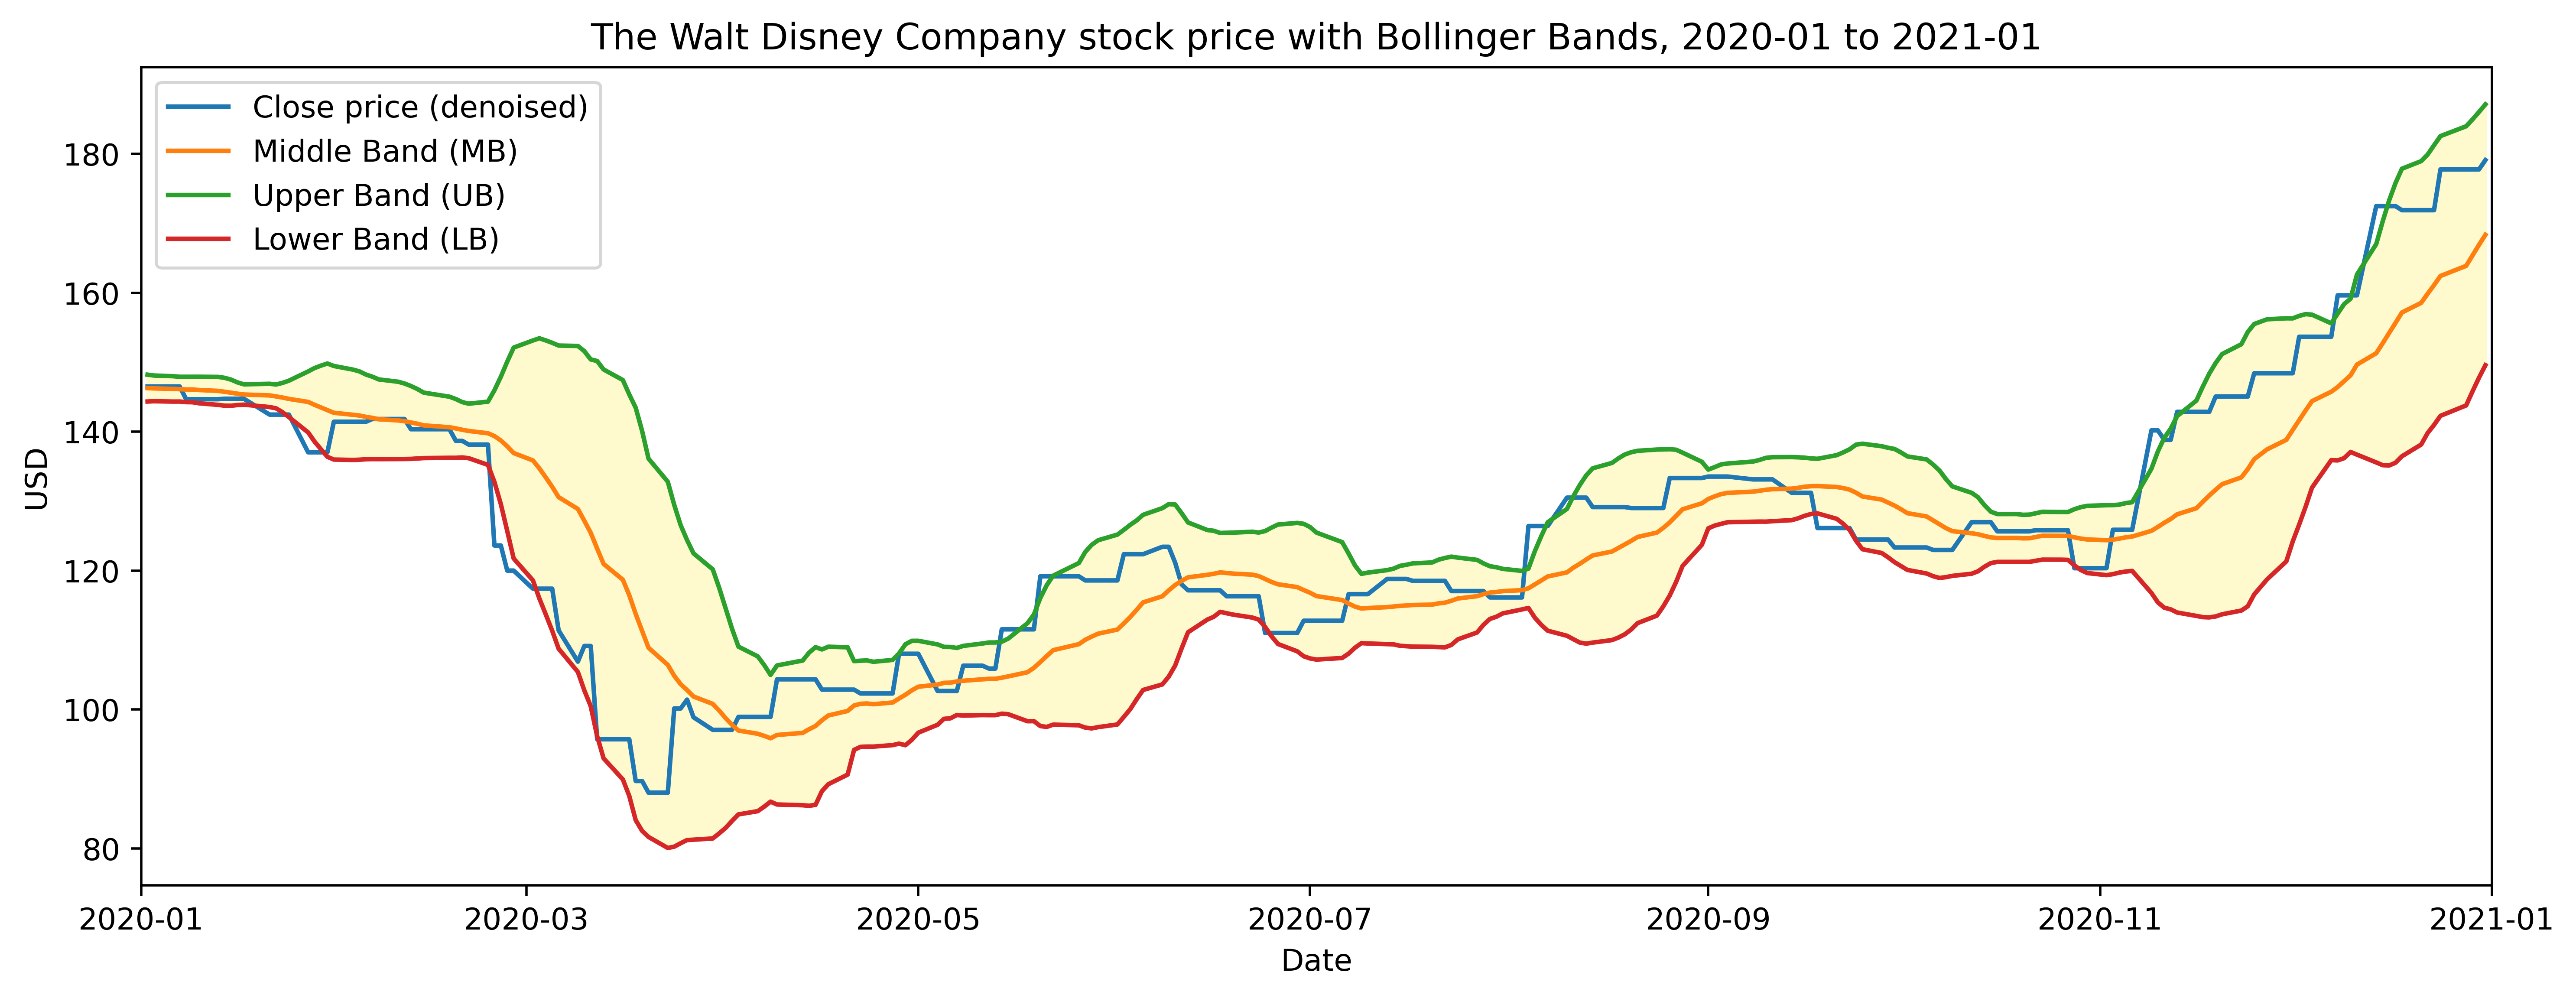

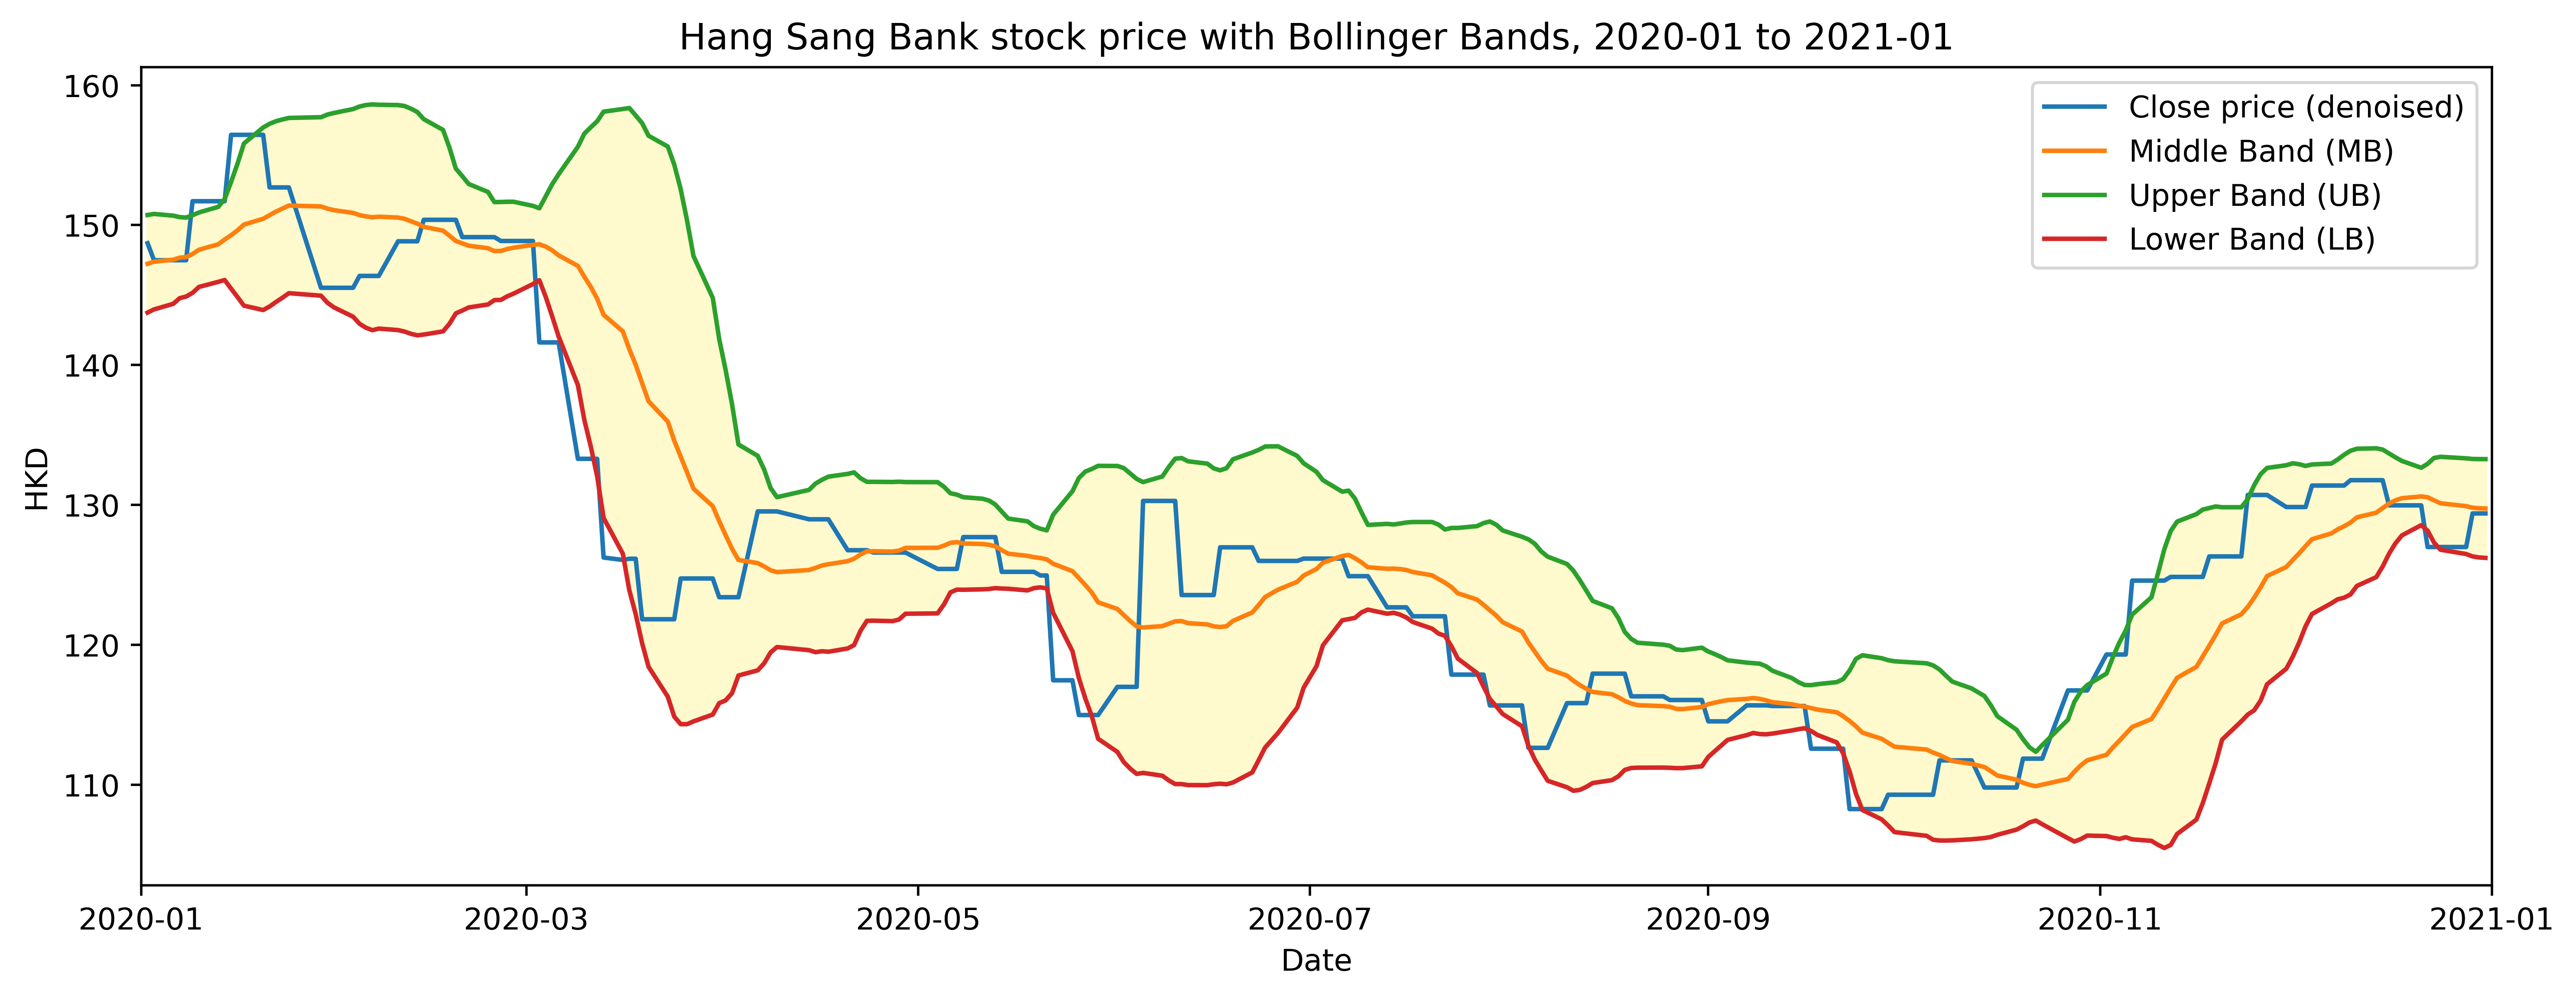

In [65]:
# diagram plotting:
# https://medium.com/python-data/setting-up-a-bollinger-band-with-python-28941e2fa300#:~:text=help%20of%20Matplotlib%E2%80%99s-,fill_between,-method.
# use ax.fill_between(x_axis, fb['Upper Band'], fb['Lower Band'], color='grey') to fill the band

# plot the Bollinger Bands
def plot_bollinger_bands(stock_index, title, stock_price_legend_label,
                         middle_band_legend_label, upper_band_legend_label,
                         lower_band_legend_label, price_currency,
                         start_day=datetime(2020, 1, 1), end_day=datetime(2021, 1, 1)):

    if not isinstance(d_feat_extr[stock_index]["Date"][0], datetime):
        d_feat_extr[stock_index]["Date"] = d_feat_extr[stock_index]["Date"].apply(parse_string_to_datetime)

    d_feat_tmp = d_feat_extr[stock_index]\
            [(d_feat_extr[stock_index]['Date']>start_day) \
             & (d_feat_extr[stock_index]['Date']<end_day)]

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(d_feat_tmp['Date'], d_feat_tmp['Close'], label=stock_price_legend_label)
    plt.plot(d_feat_tmp['Date'], d_feat_tmp['MB'], label=middle_band_legend_label)
    plt.plot(d_feat_tmp['Date'], d_feat_tmp['UB'], label=upper_band_legend_label)
    plt.plot(d_feat_tmp['Date'], d_feat_tmp['LB'], label=lower_band_legend_label)
    plt.fill_between(d_feat_tmp['Date'],
                     d_feat_tmp['UB'],
                     d_feat_tmp['LB'],
                     color='lemonchiffon'
                     )
    plt.xlabel('Date')
    plt.ylabel(price_currency)
    plt.xlim(start_day, end_day)
    plt.title(title.format(start_day.strftime("%Y-%m"), end_day.strftime("%Y-%m")))
    plt.legend()
    create_dir_if_not_exist(DIAGRAMS_PATH)
    plt.savefig('{}/{}.png'.format(DIAGRAMS_PATH, plt.gca().get_title()))
    plt.show()

plot_bollinger_bands(
    "DIS",
    "The Walt Disney Company stock price with Bollinger Bands, {} to {}",
    'Close price (denoised)',
    "Middle Band (MB)",
    "Upper Band (UB)",
    "Lower Band (LB)",
    'USD'
)

plot_bollinger_bands(
    "0011.HK",
    "Hang Sang Bank stock price with Bollinger Bands, {} to {}",
    'Close price (denoised)',
    "Middle Band (MB)",
    "Upper Band (UB)",
    "Lower Band (LB)",
    'HKD'
)


### Feature Normalization
#### Scale the data ranged from [-1, 1] using sklearn.MinMaxScaler

##### Create copy from the previous processing result and separate x, y value for normalizing

In [73]:
# copy x value
d_norm_x_raw = copy.deepcopy(d_feat_extr)
d_norm_y_raw = {}

for i in range(len(fns)):
    # x values
    d_norm_x_raw[fns[i]]['Date'] = pd.to_datetime(d_norm_x_raw[fns[i]]['Date'])
    # set "Date" column as Datetime index
    d_norm_x_raw[fns[i]] = d_norm_x_raw[fns[i]].set_index('Date')

    # y values
    d_norm_y_raw[fns[i]] = pd.DataFrame(d_norm_x_raw[fns[i]]["Close"])

    # take average of open, high, low, close to reduce dimension
    # d_norm_x_raw[fns[i]]["Avg_Price"] = d_norm_x_raw[fns[i]][["Open", "High", "Close", "Low"]].mean(axis=1)
    # d_norm_x_raw[fns[i]] = d_norm_x_raw[fns[i]].drop(columns=["Open", "High", "Close", "Low"])

print("d_norm_x_raw:")
print(d_norm_x_raw["DIS"])

print("\nd_norm_y_raw:")
print(d_norm_y_raw["DIS"])

d_norm_x_raw:
                  Open        High         Low       Close    Volume  \
Date                                                                   
2011-09-30   26.557592   27.041898   26.407898   26.533380  15135000   
2011-10-03   26.443124   26.707291   25.527344   26.533380  13899200   
2011-10-04   25.298400   26.390290   24.822900   26.533380  19000000   
2011-10-05   26.724900   27.781567   26.689677   26.533380  17823700   
2011-10-06   27.499790   28.221847   27.314874   28.472806  12659400   
...                ...         ...         ...         ...       ...   
2021-09-24  175.300003  176.699997  175.080002  175.364998   5712800   
2021-09-27  176.630005  179.449997  175.960007  175.364998   7755000   
2021-09-28  177.750000  178.000000  173.860001  175.364998   9133100   
2021-09-29  174.250000  174.960007  172.589996  175.364998   6240800   
2021-09-30  173.100006  173.679993  169.100006  169.169998  13962400   

            Dividends  Stock Splits           ACD

In [67]:
d_norm_x = {}
d_norm_y = {}

create_dir_if_not_exist(SCALER_PATH)

for i in range(len(fns)):
    # normalize x, y value
    X_scaler = MinMaxScaler(feature_range=(-1, 1))
    # X_scaler = MinMaxScaler(feature_range=(0, 1))
    y_scaler = MinMaxScaler(feature_range=(-1 ,1))
    # y_scaler = MinMaxScaler(feature_range=(0 ,1))

    # fit X_scaler and y_scaler for future use (after prediction)
    X_scaler.fit(d_norm_x_raw[fns[i]])
    y_scaler.fit(d_norm_y_raw[fns[i]])

    # do fit transform
    d_norm_x[fns[i]] = X_scaler.fit_transform(d_norm_x_raw[fns[i]])
    d_norm_y[fns[i]] = y_scaler.fit_transform(d_norm_y_raw[fns[i]])

    #Save the scalers with joblib: https://stackoverflow.com/a/41993653/9500852
    joblib.dump(X_scaler, "{}/{}.X_scaler.joblib".format(SCALER_PATH, fns[i]))
    joblib.dump(y_scaler, "{}/{}.y_scaler.joblib".format(SCALER_PATH, fns[i]))

    print("Scaling {} OK".format(fns[i]))

# display Disney to demonstrate the scaled data
print("\nd_norm_x[\"DIS\"]:")
print(d_norm_x["DIS"])

print("\nd_norm_y[\"DIS\"]:")
print(d_norm_y["DIS"])

Scaling UAL OK
Scaling 1109.HK OK
Scaling V OK
Scaling 2313.HK OK
Scaling 0027.HK OK
Scaling 3968.HK OK
Scaling WU OK
Scaling MSI OK
Scaling FCX OK
Scaling 0003.HK OK
Scaling ADM OK
Scaling 0011.HK OK
Scaling GPN OK
Scaling 0857.HK OK
Scaling ARE OK
Scaling 0001.HK OK
Scaling 0101.HK OK
Scaling FMC OK
Scaling AIZ OK
Scaling BXP OK
Scaling 1398.HK OK
Scaling 0005.HK OK
Scaling 0941.HK OK
Scaling 0066.HK OK
Scaling 2331.HK OK
Scaling 0017.HK OK
Scaling 1093.HK OK
Scaling 0388.HK OK
Scaling 2319.HK OK
Scaling 0762.HK OK
Scaling 2628.HK OK
Scaling 1044.HK OK
Scaling RL OK
Scaling 0241.HK OK
Scaling FTNT OK
Scaling JNPR OK
Scaling DHI OK
Scaling 2020.HK OK
Scaling EXPE OK
Scaling 1928.HK OK
Scaling KO OK
Scaling WDC OK
Scaling LUMN OK
Scaling UPS OK
Scaling MSFT OK
Scaling UDR OK
Scaling COO OK
Scaling 2018.HK OK
Scaling MLM OK
Scaling 0267.HK OK
Scaling AMD OK
Scaling ZBH OK
Scaling 0386.HK OK
Scaling UHS OK
Scaling SBAC OK
Scaling 0002.HK OK
Scaling 0669.HK OK
Scaling LKQ OK
Scaling PVH O

### Dimensionality Reduction
##### Reduce the dimensionality of extracted feature in X with PCA (n_components=2)

In [68]:
pca_x = {}

for i in range(len(fns)):
    pca_instance = PCA(
        n_components=2
    )

    # reduce the dimensionality of the extracted features
    tmp_pcaed = pca_instance.fit_transform(d_norm_x[fns[i]][:, 7:])

    # save to new dict
    pca_x[fns[i]] = np.c_[copy.deepcopy(d_norm_x[fns[i]][:, :7]), tmp_pcaed]

print("Shape of the stocks after PCA (e.g. DIS)")
print(pca_x["DIS"].shape)

pca_x["DIS"]

Shape of the stocks after PCA (e.g. DIS)
(2517, 9)


array([[-0.98560031, -0.99262177, -0.98141606, ..., -1.        ,
        -1.93971827, -0.06284203],
       [-0.98690933, -0.99641057, -0.99174046, ..., -1.        ,
        -1.93216388, -0.04152913],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.91121598,  0.00399164],
       ...,
       [ 0.74338388,  0.71669541,  0.74744565, ..., -1.        ,
         1.93356224, -0.58975235],
       [ 0.70335909,  0.68227319,  0.73255497, ..., -1.        ,
         1.93644554, -0.54665118],
       [ 0.69020815,  0.66777944,  0.69163518, ..., -1.        ,
         1.91274977, -0.5860336 ]])

### Data Organization
##### Organize (Reshape) the data where the X includes [t-30, t-29, ..., t] to predict Close price (Y) at time t

In [80]:
time_lag = 30 # days
to_organize_x = copy.deepcopy(pca_x)
# to_organize_x = copy.deepcopy(d_norm_x)
to_organize_y = copy.deepcopy(d_norm_y)
organized_x = {}
organized_y = {}
organized_y_gan = {} # special y for gan unsupervised training

# TODO: need to reshape to [batch, timesteps, feature]
#  where the timesteps should be equals to time lag (30)
# [row, timelag, features]

for i in range(0, len(fns)): # loop on the stocks
    tmp_x = []
    tmp_y = []
    tmp_y_gan = []
    for t in range(time_lag, len(to_organize_x[fns[i]])): # loop on the time
        tmp_x.append(to_organize_x[fns[i]][t - time_lag : t][:, :]) # get features from t-30 to t
        tmp_y.append(to_organize_y[fns[i]][t])
        tmp_y_gan.append(to_organize_x[fns[i]][t]) # copy all the features of time t as y value for gan training

    organized_x[fns[i]] = np.array(tmp_x)
    organized_y[fns[i]] = np.array(tmp_y)
    organized_y_gan[fns[i]] = np.array(tmp_y_gan)

print(organized_x["DIS"].shape)
print(organized_y["DIS"].shape)
print(organized_y_gan["DIS"].shape)

(2487, 30, 9)
(2487, 1)
(2487, 9)


In [82]:
# Use assert to check whether the shape of respective us stocks and hk stocks are consistent
us_shape = {
    "x": organized_x["DIS"].shape,
    "y": organized_y["DIS"].shape,
    "y_gan": organized_y_gan["DIS"].shape
}
hk_shape = {
    "x": organized_x["0011.HK"].shape,
    "y": organized_y["0011.HK"].shape,
    "y_gan": organized_y_gan["0011.HK"].shape
}


checked_count = 0
for i in range(len(fns)):
    if fns[i] in stocks_for_gen_testing_only: # skip the stocks that test for generalizability
        print("{} excluded as it is only for testing".format(fns[i]))
        checked_count = checked_count + 1 # treat as checked
        continue

    print("Validating {}".format(fns[i]), end=" ")

    tmp_shape_x = hk_shape["x"] if (is_stock_hk(fns[i].upper())) else us_shape["x"]
    tmp_shape_y = hk_shape["y"] if (is_stock_hk(fns[i].upper())) else us_shape["y"]
    tmp_shape_y_gan = hk_shape["y_gan"] if (is_stock_hk(fns[i].upper())) else us_shape["y_gan"]
    assert tmp_shape_x == organized_x[fns[i]].shape
    assert tmp_shape_y == organized_y[fns[i]].shape
    assert tmp_shape_y_gan == organized_y_gan[fns[i]].shape

    print("OK")
    checked_count = checked_count + 1

print("\nOrganized total: {}".format(checked_count))

Validating UAL OK
Validating 1109.HK OK
Validating V OK
Validating 2313.HK OK
Validating 0027.HK OK
Validating 3968.HK OK
Validating WU OK
Validating MSI OK
Validating FCX OK
Validating 0003.HK OK
Validating ADM OK
Validating 0011.HK OK
Validating GPN OK
Validating 0857.HK OK
Validating ARE OK
Validating 0001.HK OK
Validating 0101.HK OK
Validating FMC OK
Validating AIZ OK
Validating BXP OK
Validating 1398.HK OK
Validating 0005.HK OK
Validating 0941.HK OK
Validating 0066.HK OK
Validating 2331.HK OK
Validating 0017.HK OK
Validating 1093.HK OK
Validating 0388.HK OK
Validating 2319.HK OK
Validating 0762.HK OK
Validating 2628.HK OK
Validating 1044.HK OK
Validating RL OK
Validating 0241.HK OK
Validating FTNT OK
Validating JNPR OK
Validating DHI OK
Validating 2020.HK OK
Validating EXPE OK
Validating 1928.HK OK
Validating KO OK
Validating WDC OK
Validating LUMN OK
Validating UPS OK
Validating MSFT OK
Validating UDR OK
Validating COO OK
Validating 2018.HK OK
Validating MLM OK
Validating 0267.HK

### Data Splitting
##### Split the data into train and test datasets, and save to disk.

In [71]:
# # name of stocks used in training
# hk_train_stock_names = []
# us_train_stock_names = []
#
# test_size = 0.2
#
# template_filename_train_x = "{}/{}_train_X.npy"
# template_filename_train_y = "{}/{}_train_y.npy"
#
# template_filename_test_x = "{}/{}_test_X.npy"
# template_filename_test_y = "{}/{}_test_y.npy"
#
# create_dir_if_not_exist(TRAINING_STOCKS_PATH)
# create_dir_if_not_exist(EVALUATE_STOCKS_PATH)
#
# for i in range(len(fns)):
#     tmp_x = copy.deepcopy(organized_x[fns[i]])
#     tmp_y = copy.deepcopy(organized_y[fns[i]])
#
#     # tmp_X_train, tmp_X_test, tmp_y_train, tmp_y_test = train_test_split(
#     #     tmp_x, tmp_y, test_size=test_size, shuffle=False
#     # )
#     train_size = round(len(tmp_x) * (1-test_size))
#     tmp_X_train = tmp_x[0:train_size]
#     tmp_X_test = tmp_x[train_size: ]
#     tmp_y_train = tmp_y[0:train_size]
#     tmp_y_test = tmp_y[train_size: ]
#
#     if fns[i] in stocks_for_testing:
#         np.save(
#             template_filename_test_x.format(EVALUATE_STOCKS_PATH, fns[i]),
#             tmp_x if (fns[i] in stocks_for_gen_testing_only) else tmp_X_test
#         )
#         np.save(
#             template_filename_test_y.format(EVALUATE_STOCKS_PATH, fns[i]),
#             tmp_y if (fns[i] in stocks_for_gen_testing_only) else tmp_y_test
#         )
#
#         print("Separately saved test dataset for {}".format(fns[i]))
#
#         if fns[i] in stocks_for_gen_testing_only:
#             continue
#
#
#     if is_stock_hk(fns[i]):
#         hk_train_stock_names.append(fns[i])
#     else:
#         us_train_stock_names.append(fns[i])
#
#     np.save(
#         template_filename_train_x.format(TRAINING_STOCKS_PATH, fns[i]),
#         np.array(tmp_X_train)
#     )
#     np.save(
#         template_filename_train_y.format(TRAINING_STOCKS_PATH, fns[i]),
#         np.array(tmp_y_train)
#     )
#
#     np.save(
#         template_filename_test_x.format(TRAINING_STOCKS_PATH, fns[i]),
#         np.array(tmp_X_test)
#     )
#     np.save(
#         template_filename_test_y.format(TRAINING_STOCKS_PATH, fns[i]),
#         np.array(tmp_y_test)
#     )
#
#     print("Saved the train and test datasets for {}.".format(fns[i]), end=" ")
#     print("X_train shape: {}; y_train shape: {}; X_test shape: {}; y_test shape: {}".format(
#         np.array(tmp_X_train).shape,
#         np.array(tmp_y_train).shape,
#         np.array(tmp_X_test).shape,
#         np.array(tmp_y_test).shape
#     ))
#
# # save stock names array
# create_dir_if_not_exist(TRAIN_STOCK_NAMES_PATH)
# np.save("{}/hk_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH), np.array(hk_train_stock_names))
# np.save("{}/us_train_stock_names.npy".format(TRAIN_STOCK_NAMES_PATH), np.array(us_train_stock_names))
#
# print("\nSaved the name of stocks that will be used in training")

##### The time range that used for evaluation, and the two stocks that used for evaluating the generalizability, should be excluded from the datasets and save as a separate files

In [84]:
train_X_hk = []
train_X_us = []

train_y_hk = []
train_y_us = []

train_y_gan_hk = []
train_y_gan_us = []

test_X_hk = []
test_X_us = []

test_y_hk = []
test_y_us = []

test_y_gan_hk = []
test_y_gan_us = []

test_size = 0.2

template_filename_test_x = "{}/{}_test_X.npy"
template_filename_test_y = "{}/{}_test_y.npy"

create_dir_if_not_exist(TRAINING_STOCKS_PATH)
create_dir_if_not_exist(EVALUATE_STOCKS_PATH)

for i in range(len(fns)):
    tmp_x = copy.deepcopy(organized_x[fns[i]])
    tmp_y = copy.deepcopy(organized_y[fns[i]])
    tmp_y_gan = copy.deepcopy(organized_y_gan[fns[i]])

    tmp_X_train, tmp_X_test, tmp_y_train, tmp_y_test, \
    tmp_y_gan_train, tmp_y_gan_test = train_test_split(
        tmp_x, tmp_y, tmp_y_gan, test_size=test_size, shuffle=False
    )

    if fns[i] in stocks_for_testing:
        np.save(
            template_filename_test_x.format(EVALUATE_STOCKS_PATH, fns[i]),
            tmp_x if (fns[i] in stocks_for_gen_testing_only) else tmp_X_test
        )
        np.save(
            template_filename_test_y.format(EVALUATE_STOCKS_PATH, fns[i]),
            tmp_y if (fns[i] in stocks_for_gen_testing_only) else tmp_y_test
        )

        print("Separately saved test dataset for {}".format(fns[i]))
        if fns[i] in stocks_for_gen_testing_only:
            continue

    if is_stock_hk(fns[i]):
        train_X_hk.append(np.array(tmp_X_train))
        train_y_hk.append(np.array(tmp_y_train))
        train_y_gan_hk.append(np.array(tmp_y_gan_train))

        test_X_hk.append(np.array(tmp_X_test))
        test_y_hk.append(np.array(tmp_y_test))
        test_y_gan_hk.append(np.array(tmp_y_gan_test))
    else:
        train_X_us.append(np.array(tmp_X_train))
        train_y_us.append(np.array(tmp_y_train))
        train_y_gan_us.append(np.array(tmp_y_gan_train))

        test_X_us.append(np.array(tmp_X_test))
        test_y_us.append(np.array(tmp_y_test))
        test_y_gan_us.append(np.array(tmp_y_gan_test))

# save train X
np.save(
    "{}/train_X_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_X_hk)
)
np.save(
    "{}/train_X_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_X_us)
)

# save train y
np.save(
    "{}/train_y_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_y_hk)
)
np.save(
    "{}/train_y_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_y_us)
)

# save train y gan
np.save(
    "{}/train_y_gan_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_y_gan_hk)
)
np.save(
    "{}/train_y_gan_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(train_y_gan_us)
)

# save test X
np.save(
    "{}/test_X_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_X_hk)
)
np.save(
    "{}/test_X_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_X_us)
)

# save test Y
np.save(
    "{}/test_y_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_y_hk)
)
np.save(
    "{}/test_y_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_y_us)
)

# save test GAN
np.save(
    "{}/test_y_gan_hk.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_y_gan_hk)
)
np.save(
    "{}/test_y_gan_us.npy".format(TRAINING_STOCKS_PATH),
    np.concatenate(test_y_gan_us)
)

print("\nSaved the train and test datasets.")

print("\ntrain_X: HK {} and US {}".format(np.concatenate(train_X_hk).shape, np.concatenate(train_X_us).shape))
print("train_y: HK {} and US {}".format(np.concatenate(train_y_hk).shape, np.concatenate(train_y_us).shape))
print("train_y_gan: HK {} and US {}".format(np.concatenate(train_y_gan_hk).shape, np.concatenate(train_y_gan_us).shape))
print("test_x: HK {} and US {}".format(np.concatenate(test_X_hk).shape, np.concatenate(test_X_us).shape))
print("test_y: HK {} and US {}".format(np.concatenate(test_y_hk).shape, np.concatenate(test_y_us).shape))
print("test_y_gan: HK {} and US {}".format(np.concatenate(test_y_gan_hk).shape, np.concatenate(test_y_gan_us).shape))

Separately saved test dataset for MSFT
Separately saved test dataset for 1299.HK
Separately saved test dataset for 1038.HK
Separately saved test dataset for 2888.HK
Separately saved test dataset for TEAM
Separately saved test dataset for AAPL

Saved the train and test datasets.

train_X: HK (95403, 30, 9) and US (97461, 30, 9)
train_y: HK (95403, 1) and US (97461, 1)
train_y_gan: HK (95403, 9) and US (97461, 9)
test_x: HK (23863, 30, 9) and US (24402, 30, 9)
test_y: HK (23863, 1) and US (24402, 1)
test_y_gan: HK (23863, 9) and US (24402, 9)


### Other useful information for model training and evaluation

In [90]:
print("Index of `Close` column: {}".format(
    d_norm_x_raw["DIS"].columns.get_loc("Close")
))

Index of `Close` column: 3
